# Начало

In [1]:
import numpy as np

from dto import Point, GeoPoint
from SpeedPredictor import MotionConstraints, PureLateralLimitTurnPolicy, SpeedPredictor
from PumpController import BoundaryAction, PumpConstraints, PumpController
from utils import polyline_lengths, point_on_path, simulate_time_param
from plots import plot_polygon

## Загрузка лог файла

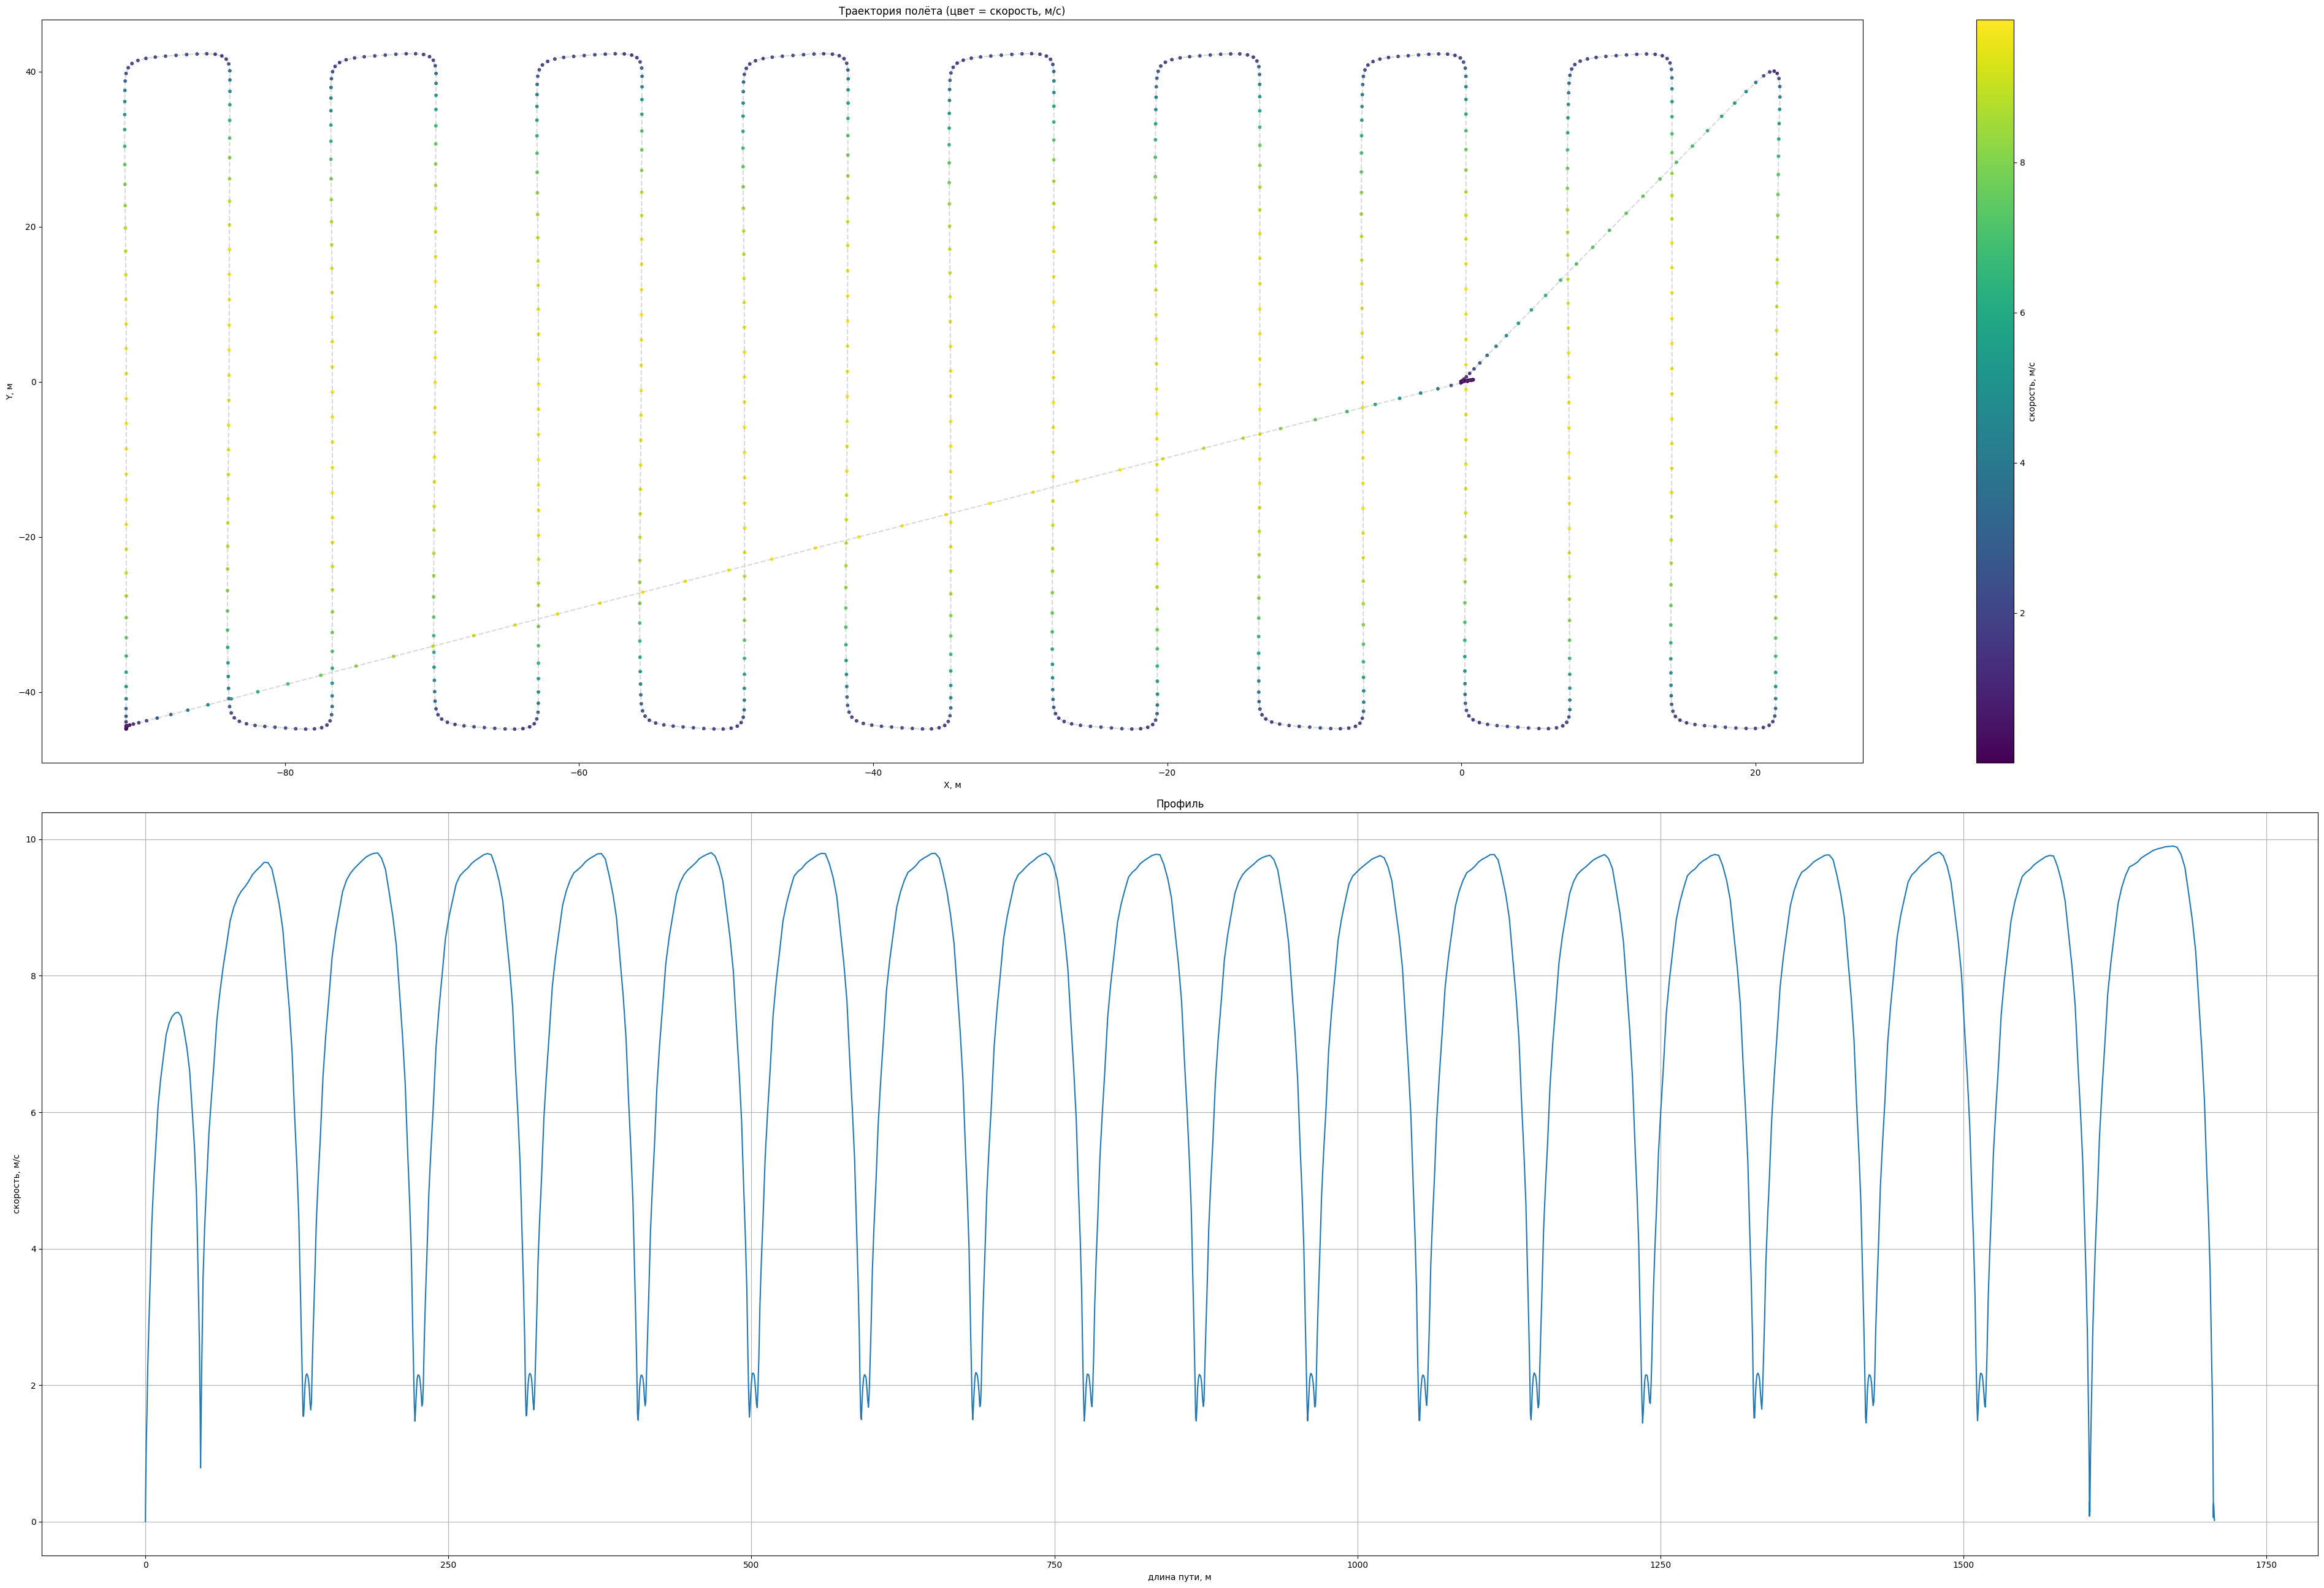

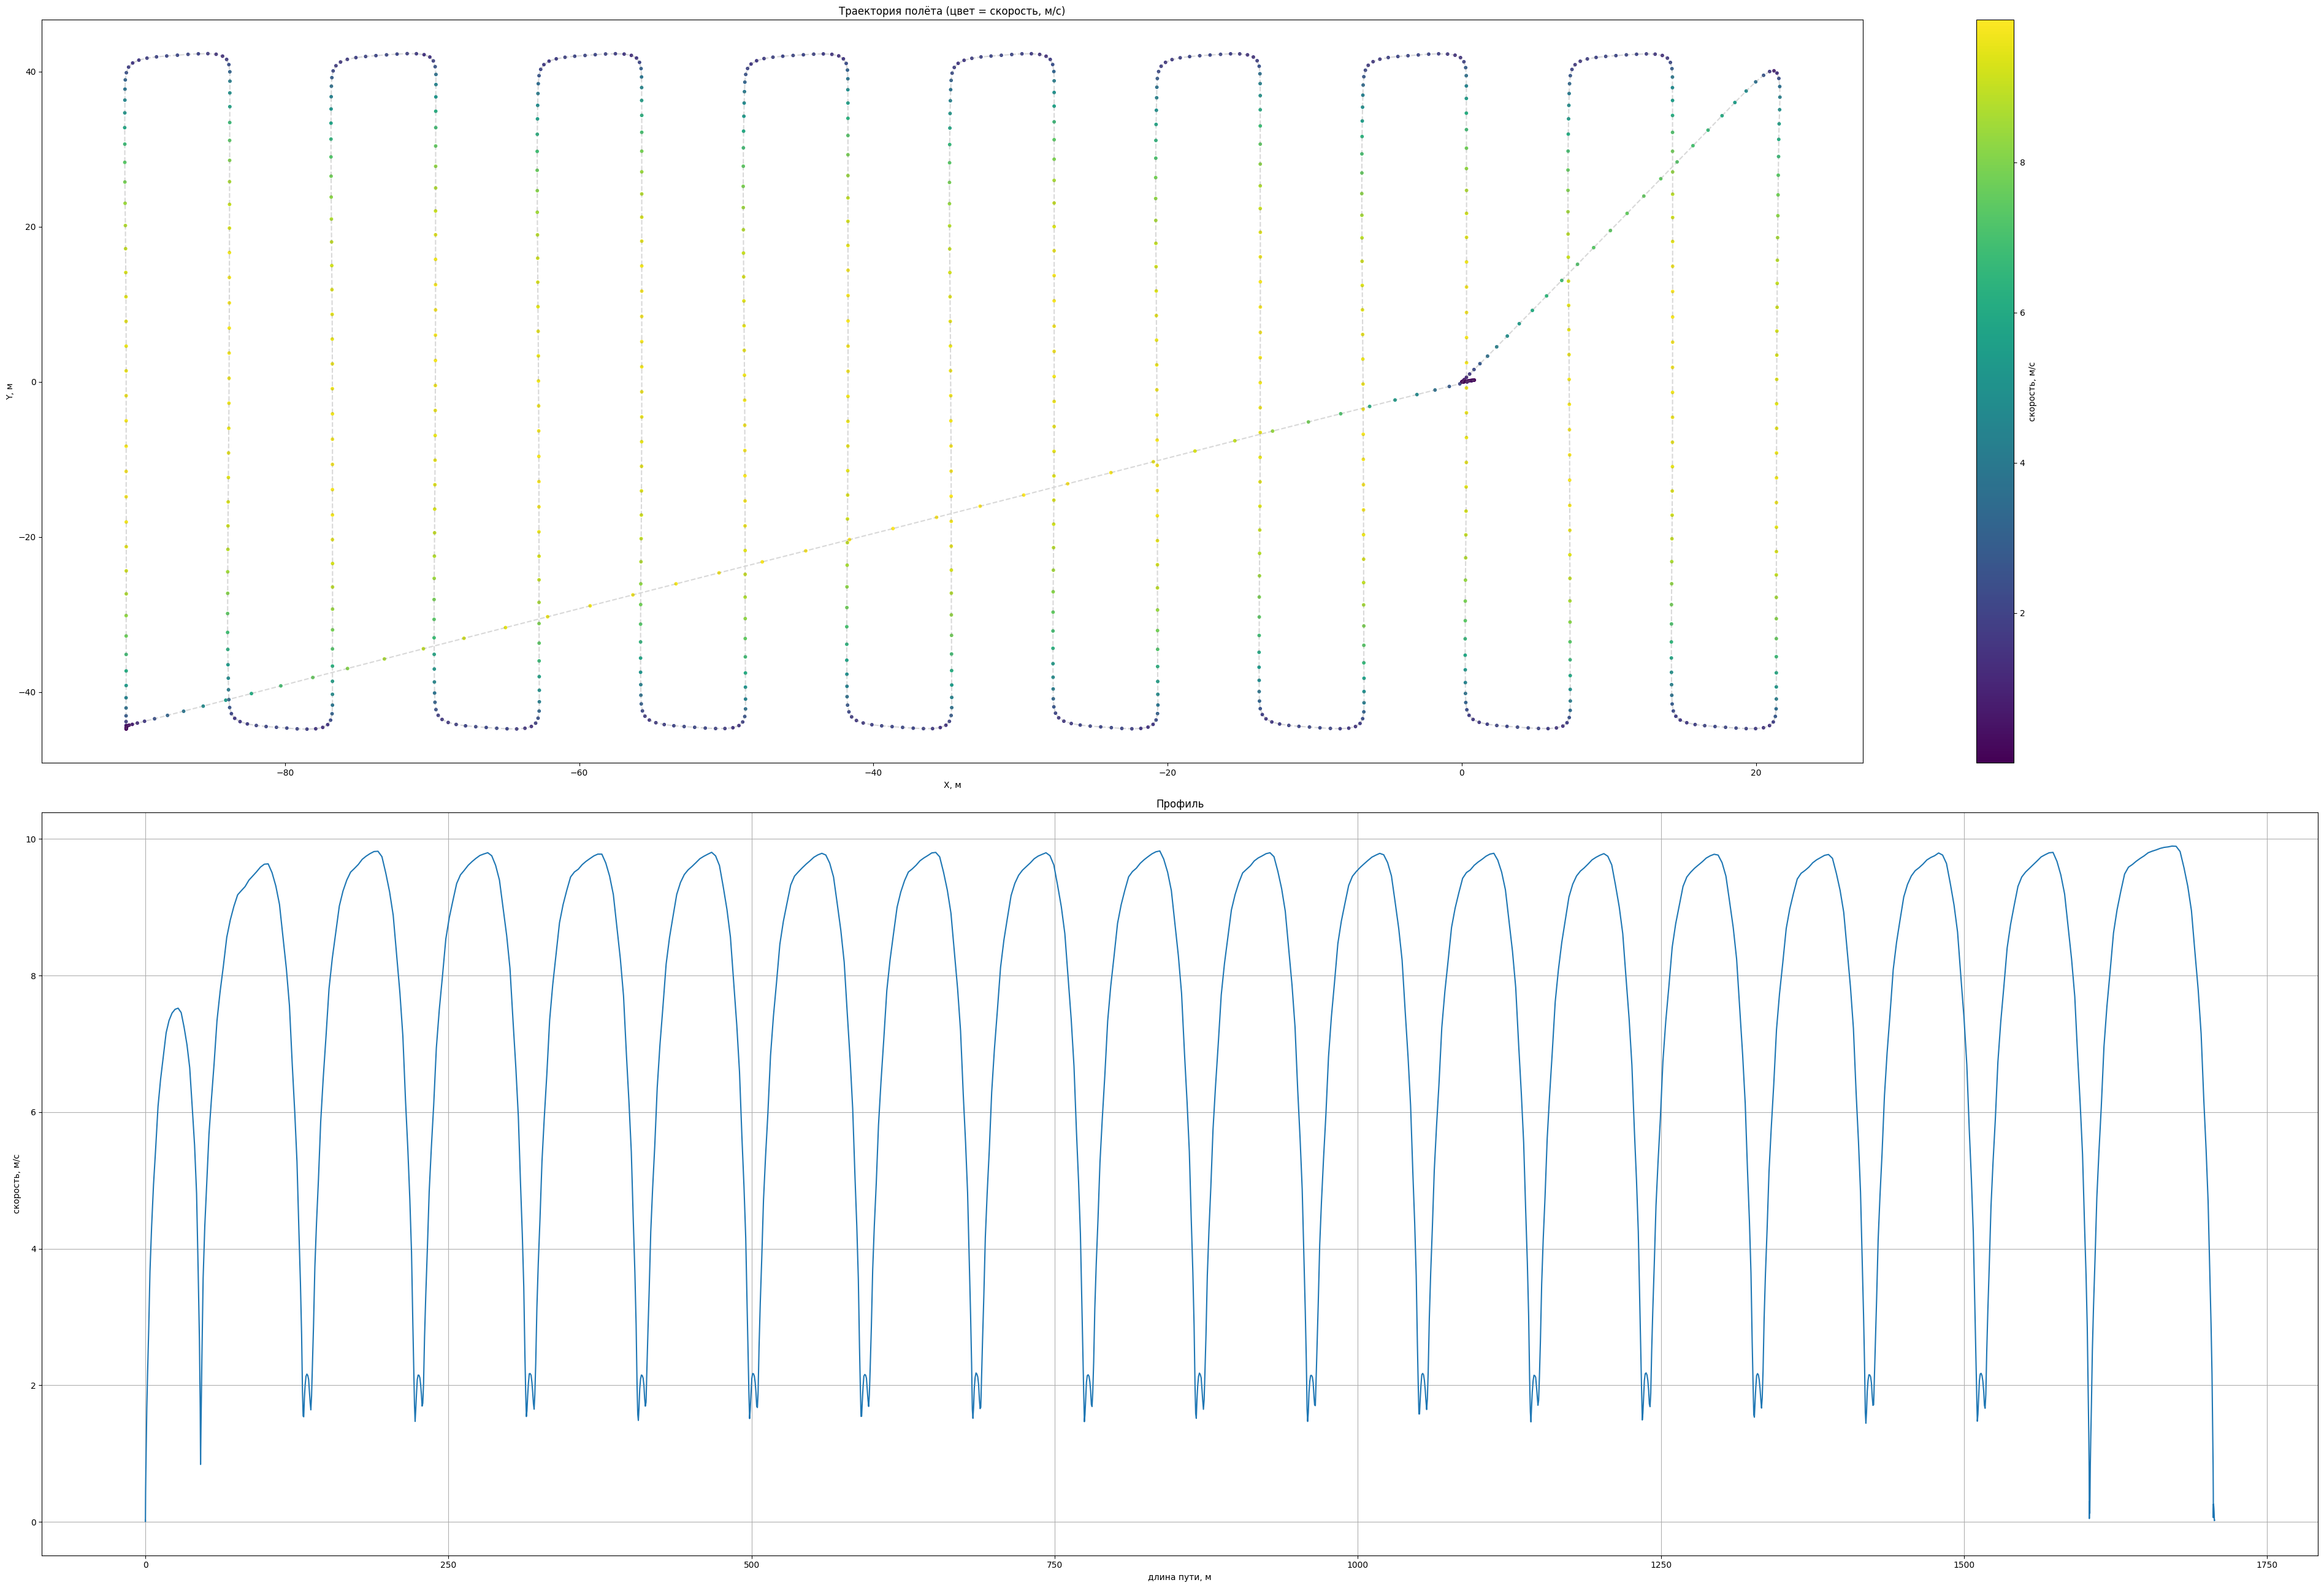

[Warning] Корректная обработка полётов в количестве более 1 ещё не реализована


In [2]:
from parse_log import Plan, Logs
from pathlib import Path

path_to_file = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(path_to_file)

in_logs = Logs(path_to_file)

## Визуализация плана мисии

In [3]:

from GeoTransformer import GeoTransformer

geo_transformer = GeoTransformer()


def to_xy(p: GeoPoint) -> Point:
    return geo_transformer.geo_to_xy(plan.center_geo, p)


def to_geo(p: Point) -> GeoPoint:
    return geo_transformer.xy_to_geo(plan.center_geo, p)


def to_xy_points(gp: list[GeoPoint]) -> list[Point]:
    return [to_xy(p) for p in gp]

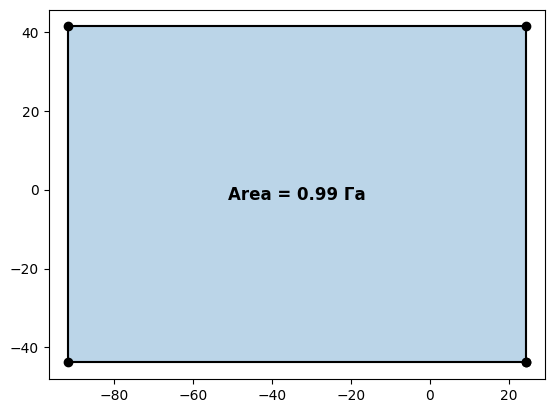

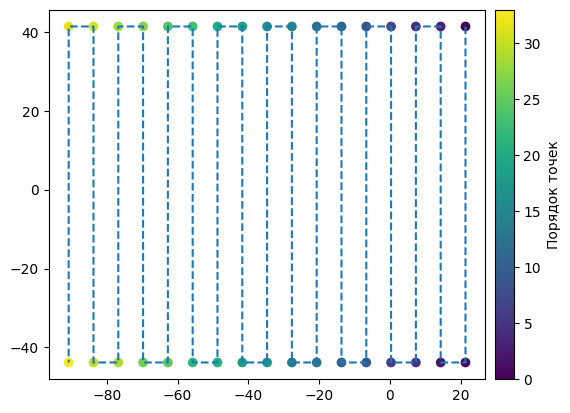

In [4]:
from plots import scatter_with_color

plot_polygon(plan.polygon)
scatter_with_color(plan.waypoints_xy, list(range(len(plan.waypoints_xy))), 'Порядок точек')

# Ограничения

In [5]:
motion = MotionConstraints(
    v_max=10.0,
    a_max=1.0,
    d_max=1.0,
    yaw_rate=90.0,
    turn_radius=0,
    a_lat_max=2.0,
    angle_eps_deg=10.0,
    start_speed=0.0,
    end_speed=0.0
)

predictor = SpeedPredictor(motion, PureLateralLimitTurnPolicy())

norma = 10  # Норма внесения Литры/Га
pump_min_speed = 1  # л/мин
pump_max_speed = 13  # л/мин
tank_volume = 40  # л

constraints = PumpConstraints(
    q_min=pump_min_speed / 60,  # л/с
    q_max=pump_max_speed / 60,  # л/с
    tank_volume=tank_volume,  # л
    low_mode=BoundaryAction.CLAMP,
    high_mode=BoundaryAction.CLAMP,
)

pump = PumpController(constraints)


# Предсказанный на основе плана

## Предсказанный профиль скорости

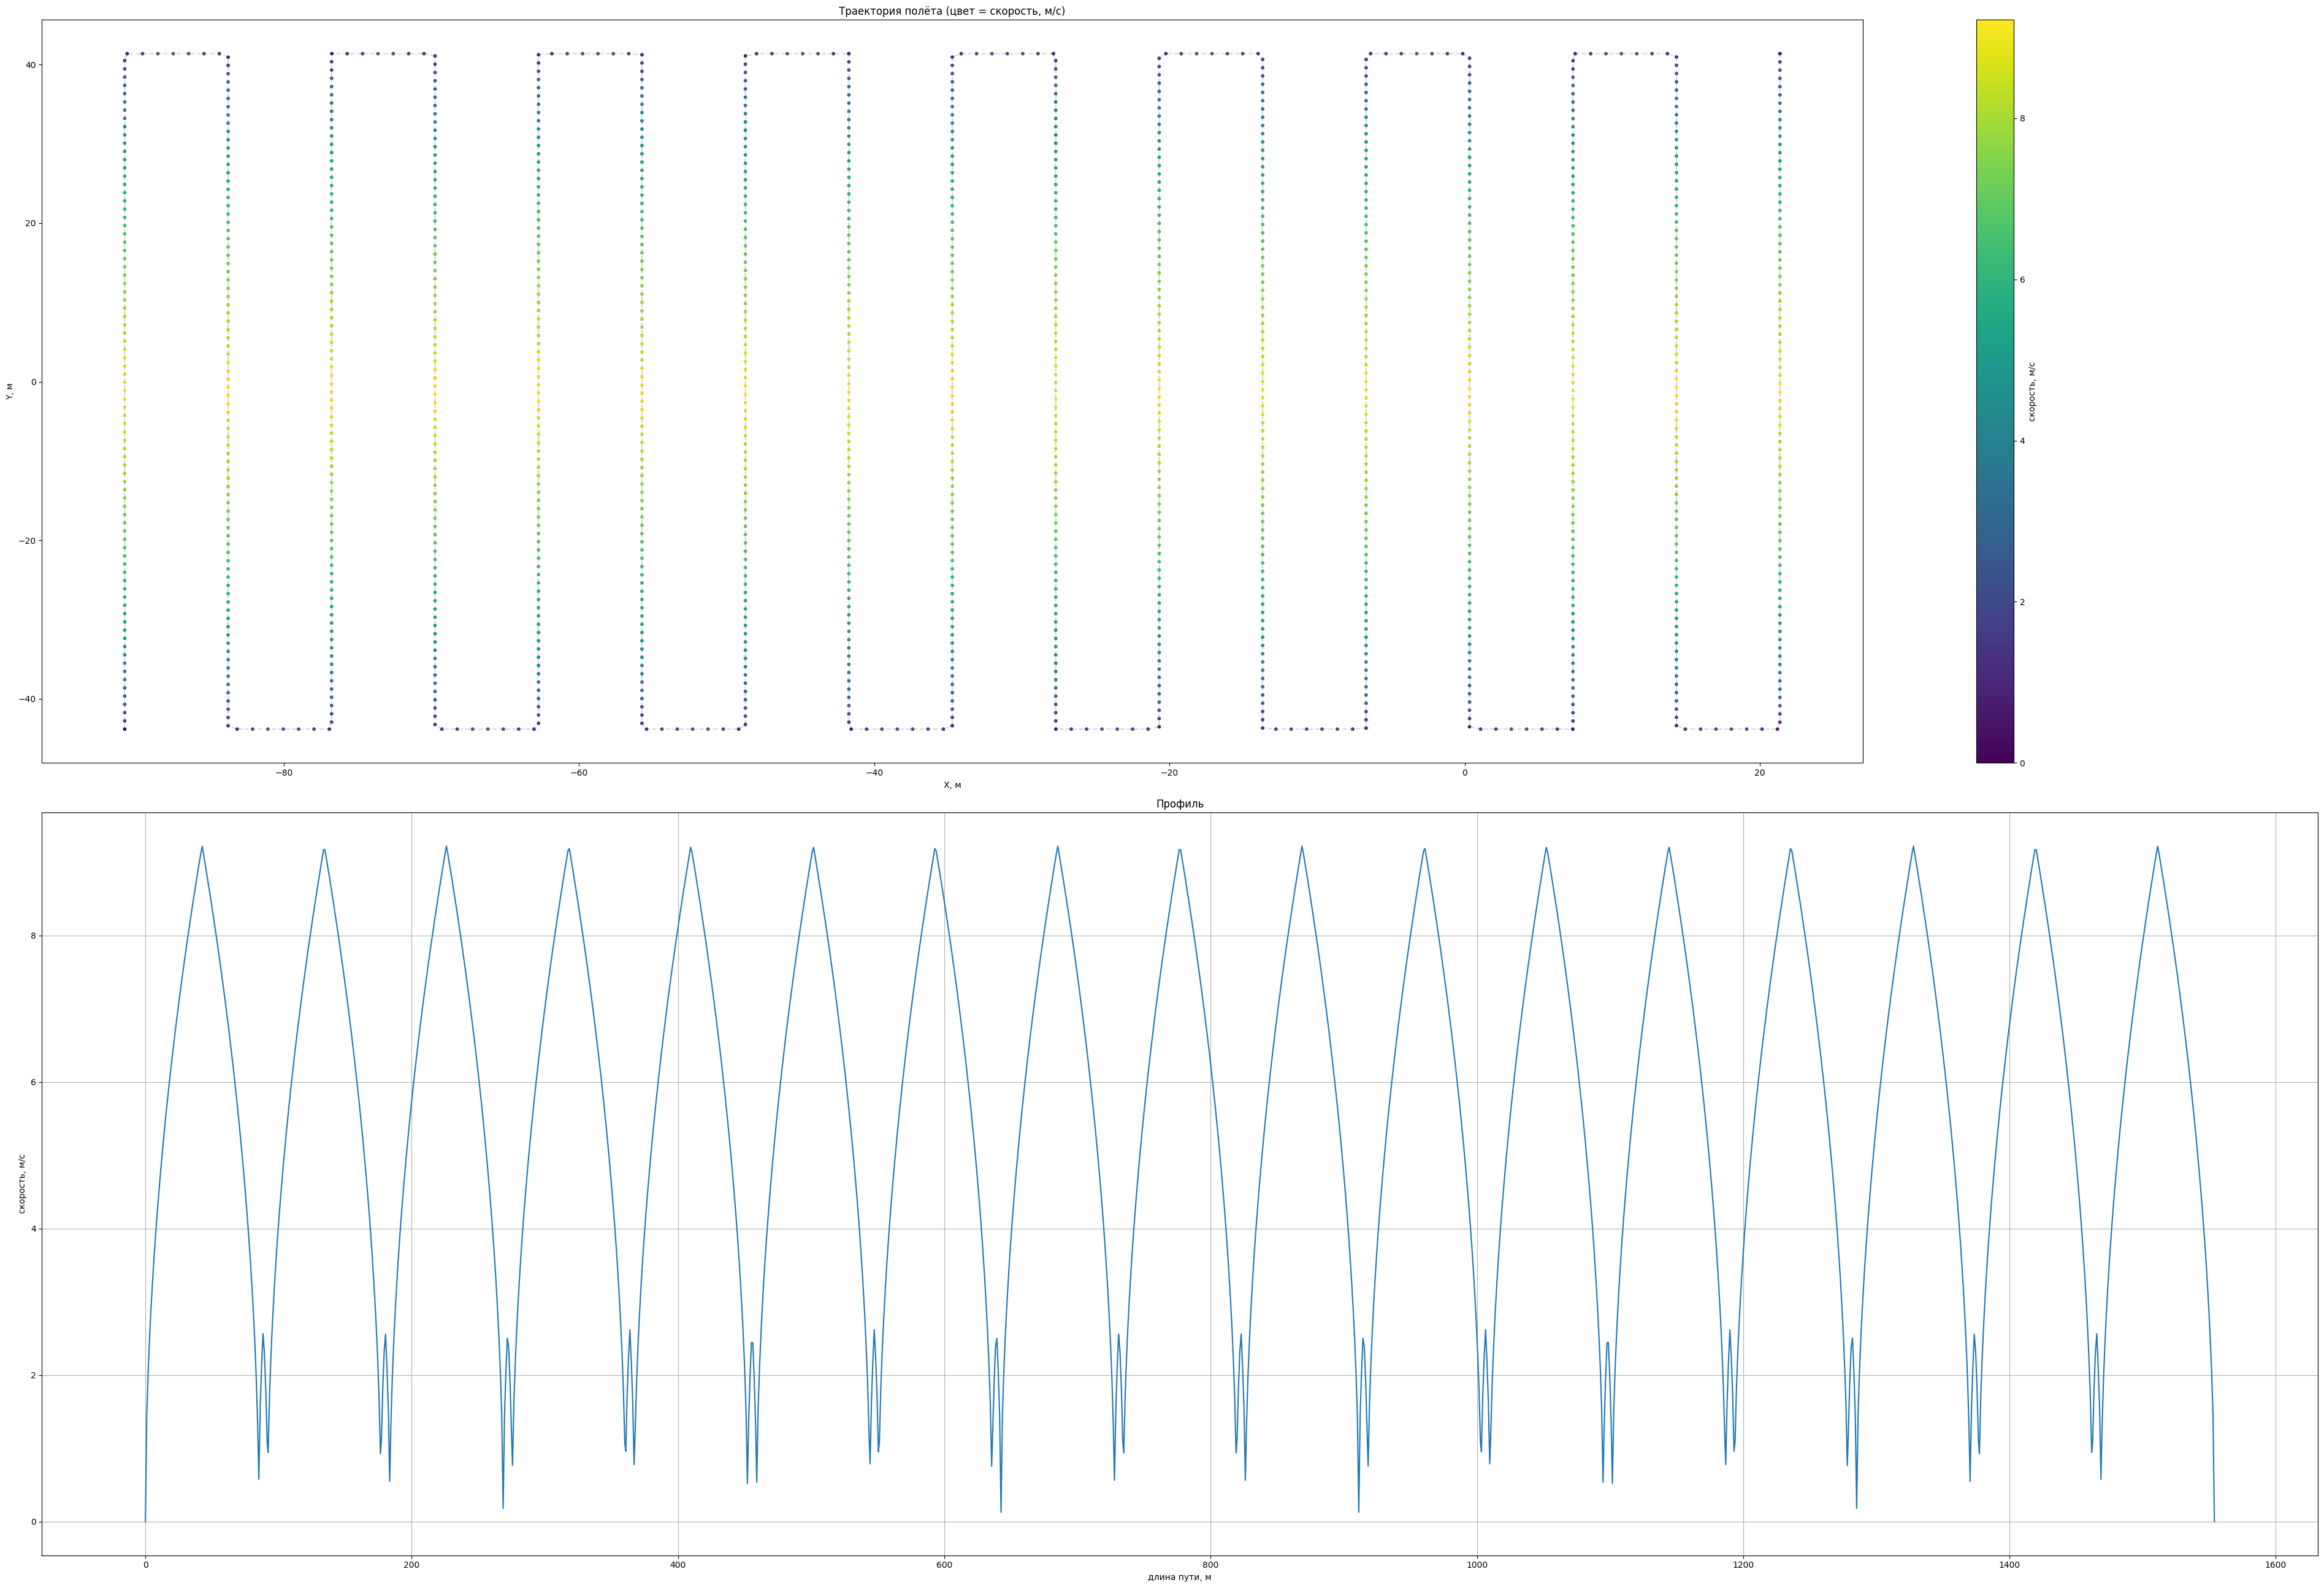

In [6]:
from plots import scatter_with_color_and_profile

profile_by_plan = predictor.build_profile(plan.waypoints_xy)

s_list = np.linspace(0, profile_by_plan.total_distance, 1500)
points = [point_on_path(plan.waypoints_xy, d) for d in s_list]
scatter_with_color_and_profile(points, [profile_by_plan.speed_at_distance(p) for p in s_list])

## Предсказанный режим работы насоса

In [7]:
from plots import plot_speeds_profile, plot_density_profile

t_list, s_list, speed_list = profile_by_plan.simulate_time_param(dt=0.1)

V_total = plan.calculate_total_volume(norma)  # л — нужно вылить на всём маршруте

pump_series_by_plan = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list,
    length=profile_by_plan.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile_by_plan.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(pump_series_by_plan) :.2f} л")
empty_s_list = [profile_by_plan.distance_at_time(t) for t, v in pump_series_by_plan.empty_events]

if pump_series_by_plan.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(pump_series_by_plan.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")

Длина маршрута L = 1560.21 м
Плановый объём V_total = 9.89 л
Фактически выльется (с учётом ограничений насоса): 11.29 л
Бак не опустошается в ходе полёта.


## Профиль скорости

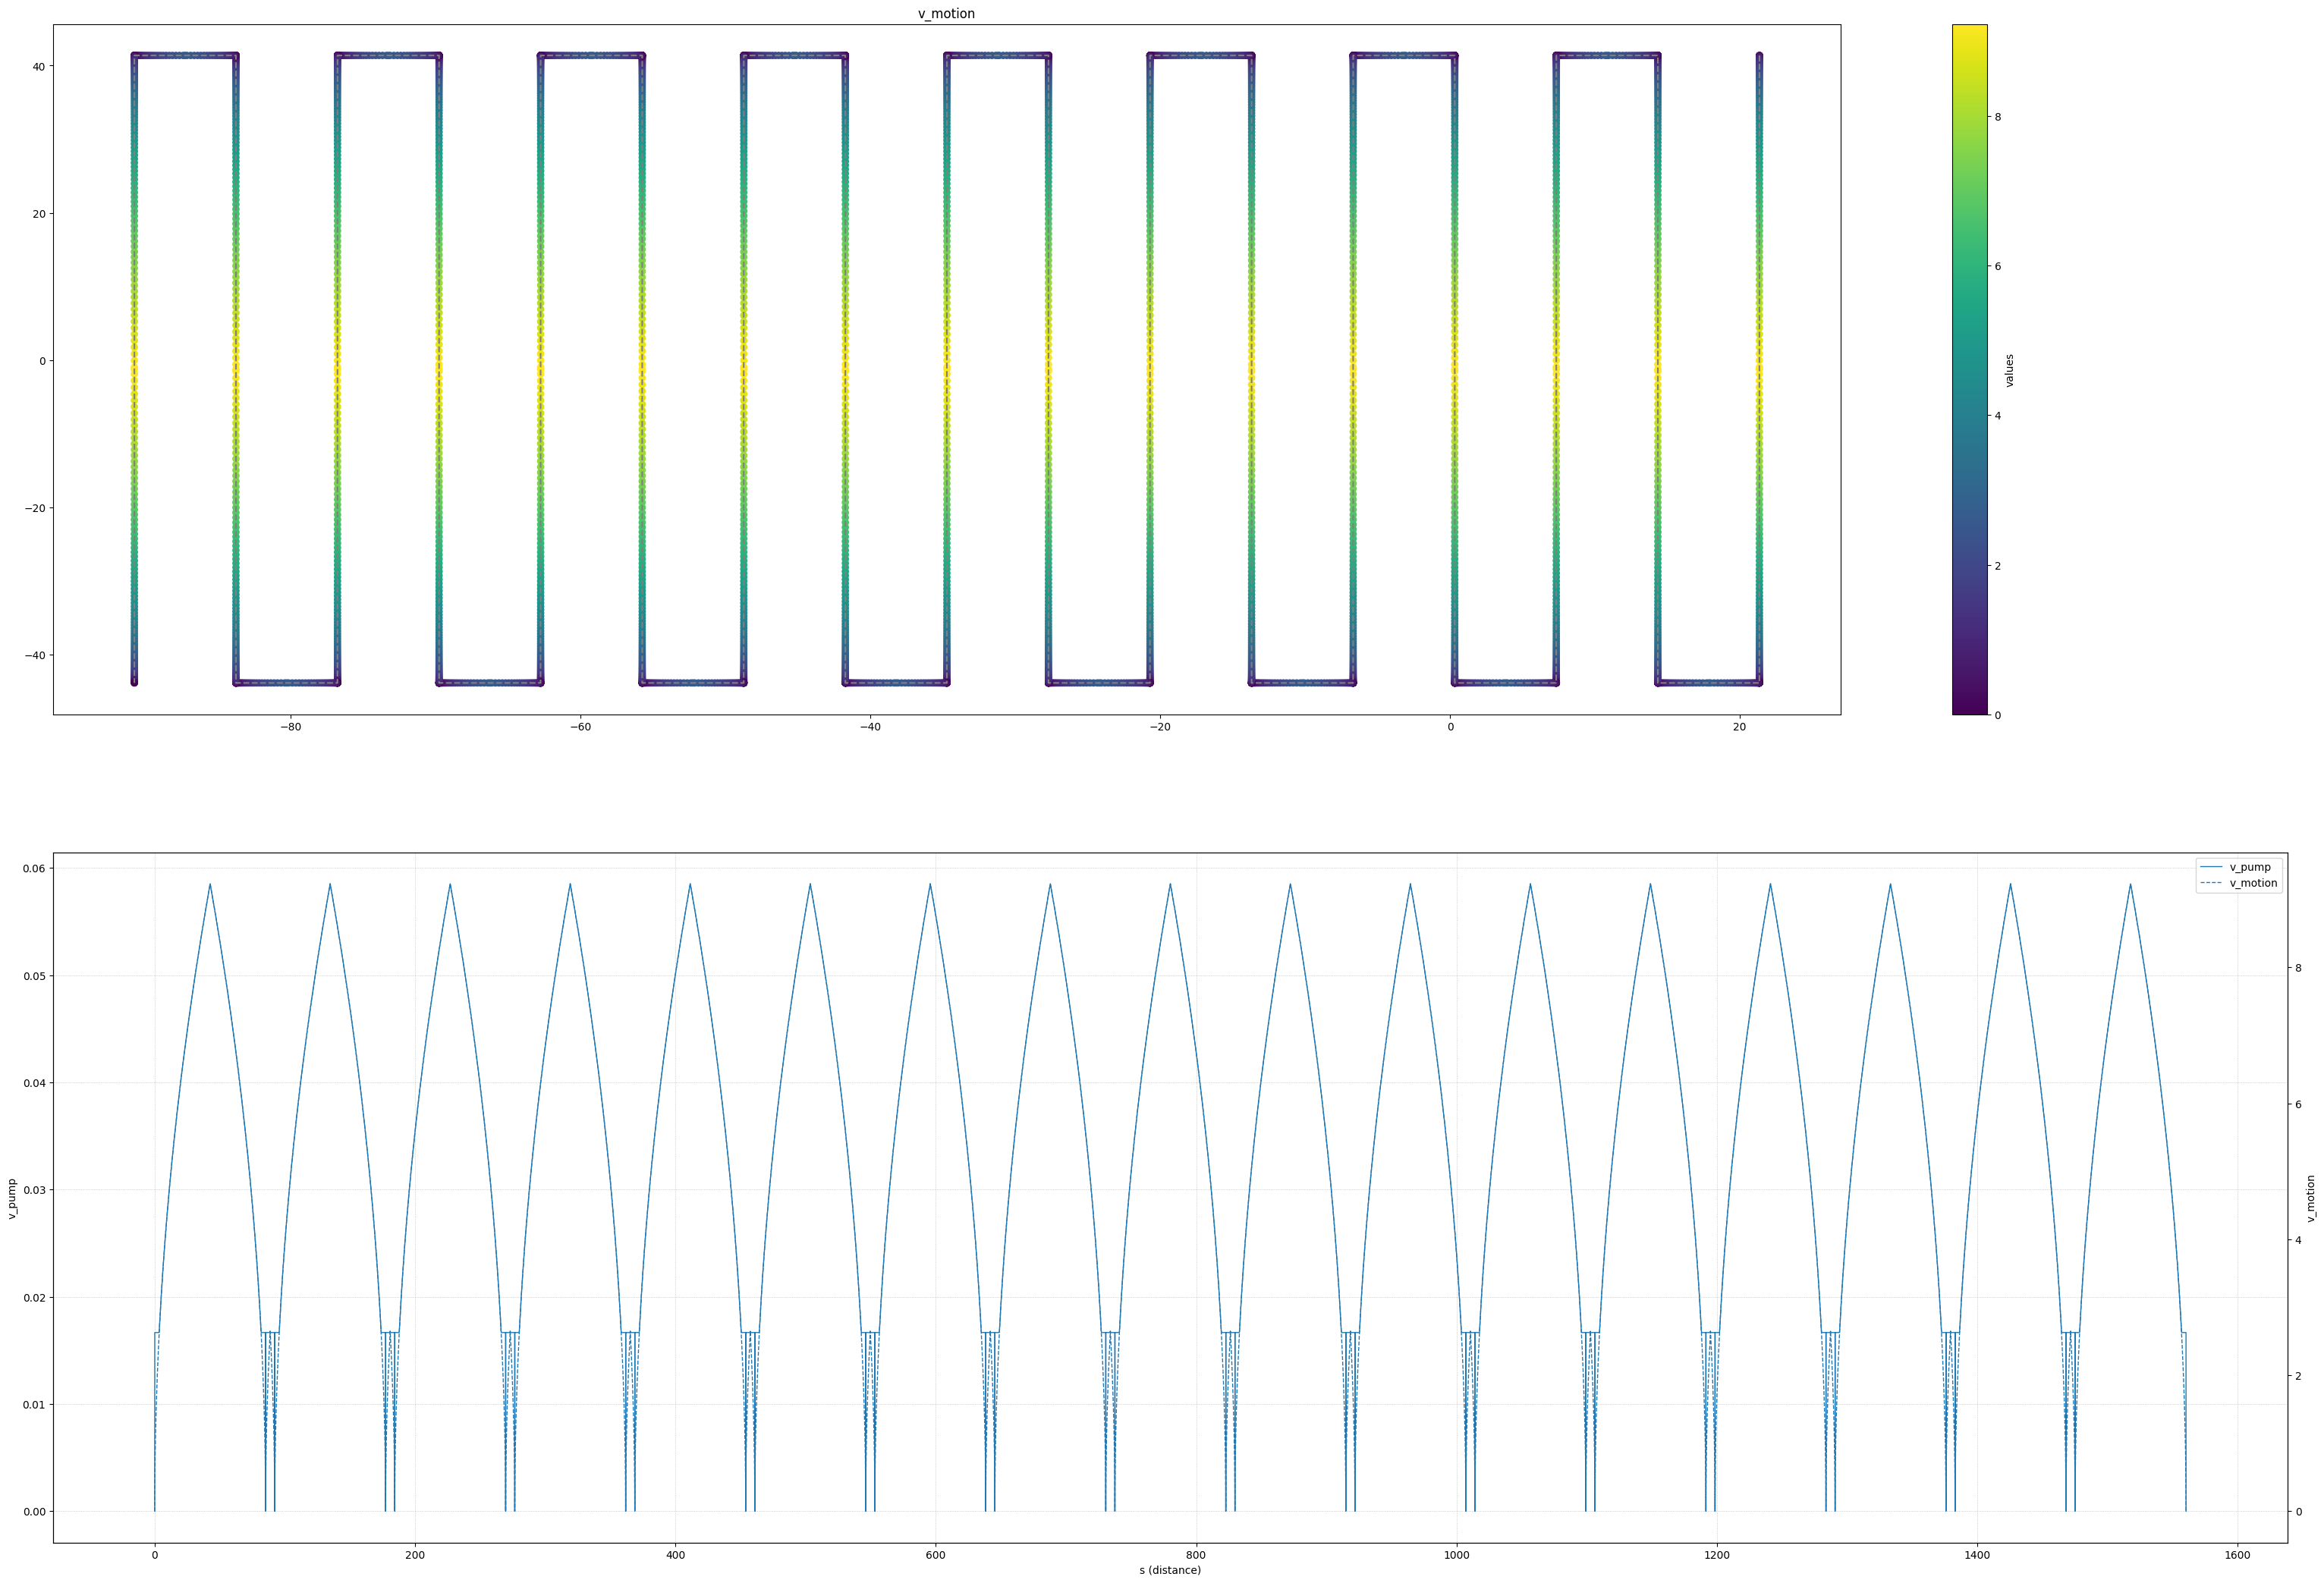

In [8]:
list_pts = [point_on_path(plan.waypoints_xy, s) for s in s_list]

plot_speeds_profile(list_pts,
                    s_list,
                    pump_series_by_plan.q,
                    speed_list,
                    empty_s_list)

## Плотность внесения

count    4298.000000
mean        0.012158
std         0.019303
min         0.000000
25%         0.006342
50%         0.006342
75%         0.009804
max         0.166667
dtype: float64
diff = 0.005816809198015352
СКО = 0.00040635875898824324


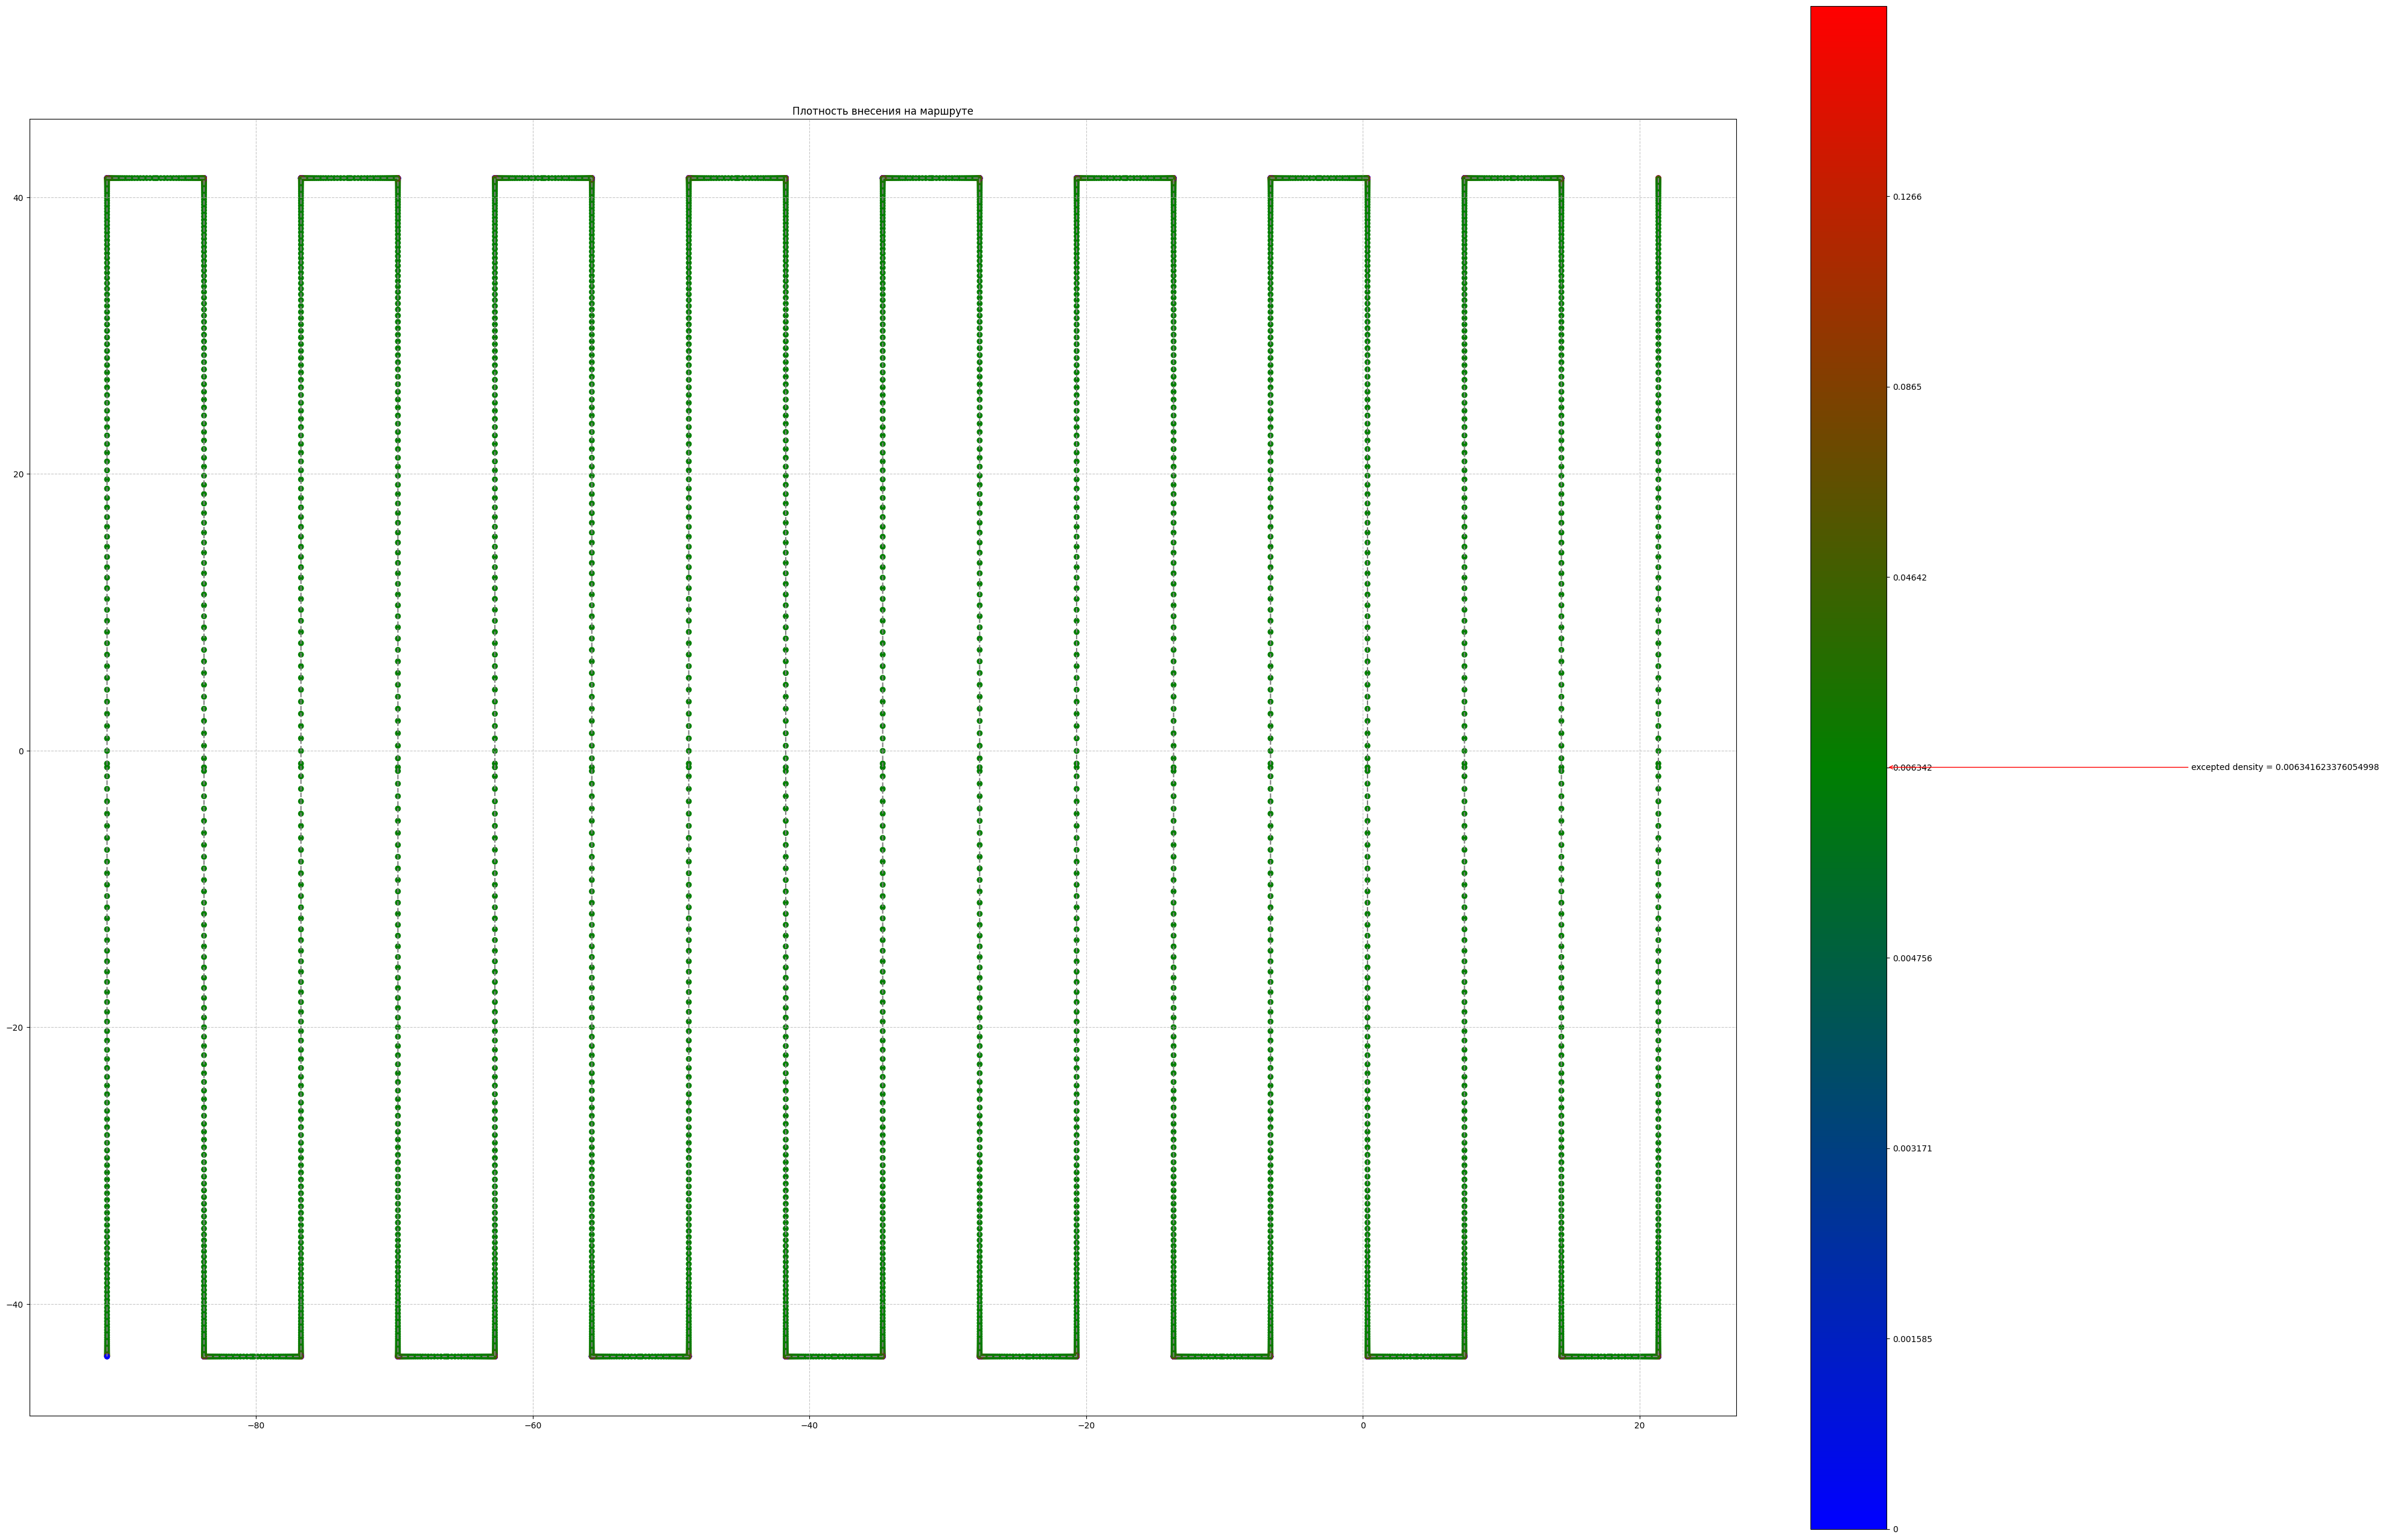

In [9]:
plot_density_profile(list_pts,
                     pump_series_by_plan.q,
                     speed_list,
                     V_total / profile_by_plan.total_distance)

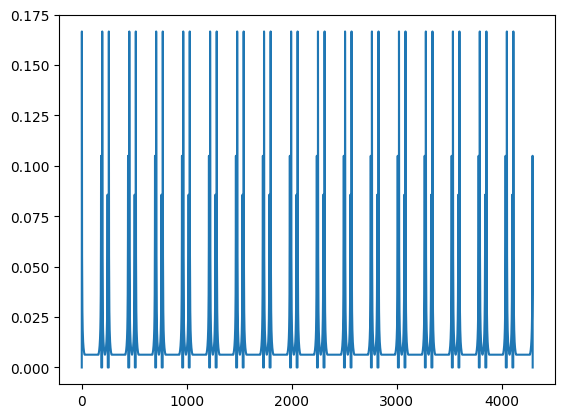

In [10]:
import matplotlib.pyplot as plt

l = PumpController.instantaneous_densities(speed_list, pump_series_by_plan.q)
plt.plot(l)

## Интегрируем, считаем вылитый объём и пройденный маршрут

In [11]:
from scipy import integrate

In [12]:
f = lambda t: pump_series_by_plan.q[np.argmin(pow(np.array(pump_series_by_plan.t) - t, 2))]
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

11.445615934335976 ± 0.3234805854180962


C:\Users\nodax\AppData\Local\Temp\ipykernel_21736\3940417807.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


In [13]:
import numpy as np

val = np.trapezoid(speed_list, pump_series_by_plan.t)
print(val)

1560.206774122365


In [14]:
from scipy.integrate import simpson

val = simpson(speed_list, x=pump_series_by_plan.t)

print(val)

1560.116807336312


In [15]:
plan.total_distance, profile_by_plan.total_distance

(1560.206774122365, 1560.206774122365)

In [16]:
from scipy import interpolate, integrate

f = interpolate.interp1d(pump_series_by_plan.t, speed_list, kind="linear")  # или "cubic"
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(val, err)

1559.2302605072705 15.490637295632496


C:\Users\nodax\AppData\Local\Temp\ipykernel_21736\4290829972.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


In [17]:
f = lambda t: speed_list[np.argmin(pow(np.array(pump_series_by_plan.t) - t, 2))]
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

1549.5048604142087 ± 45.30303863659833


C:\Users\nodax\AppData\Local\Temp\ipykernel_21736\547705918.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


# Берём данные о полёте из логов

## Визуализация всех полётов в лог файле

Полёт № 1


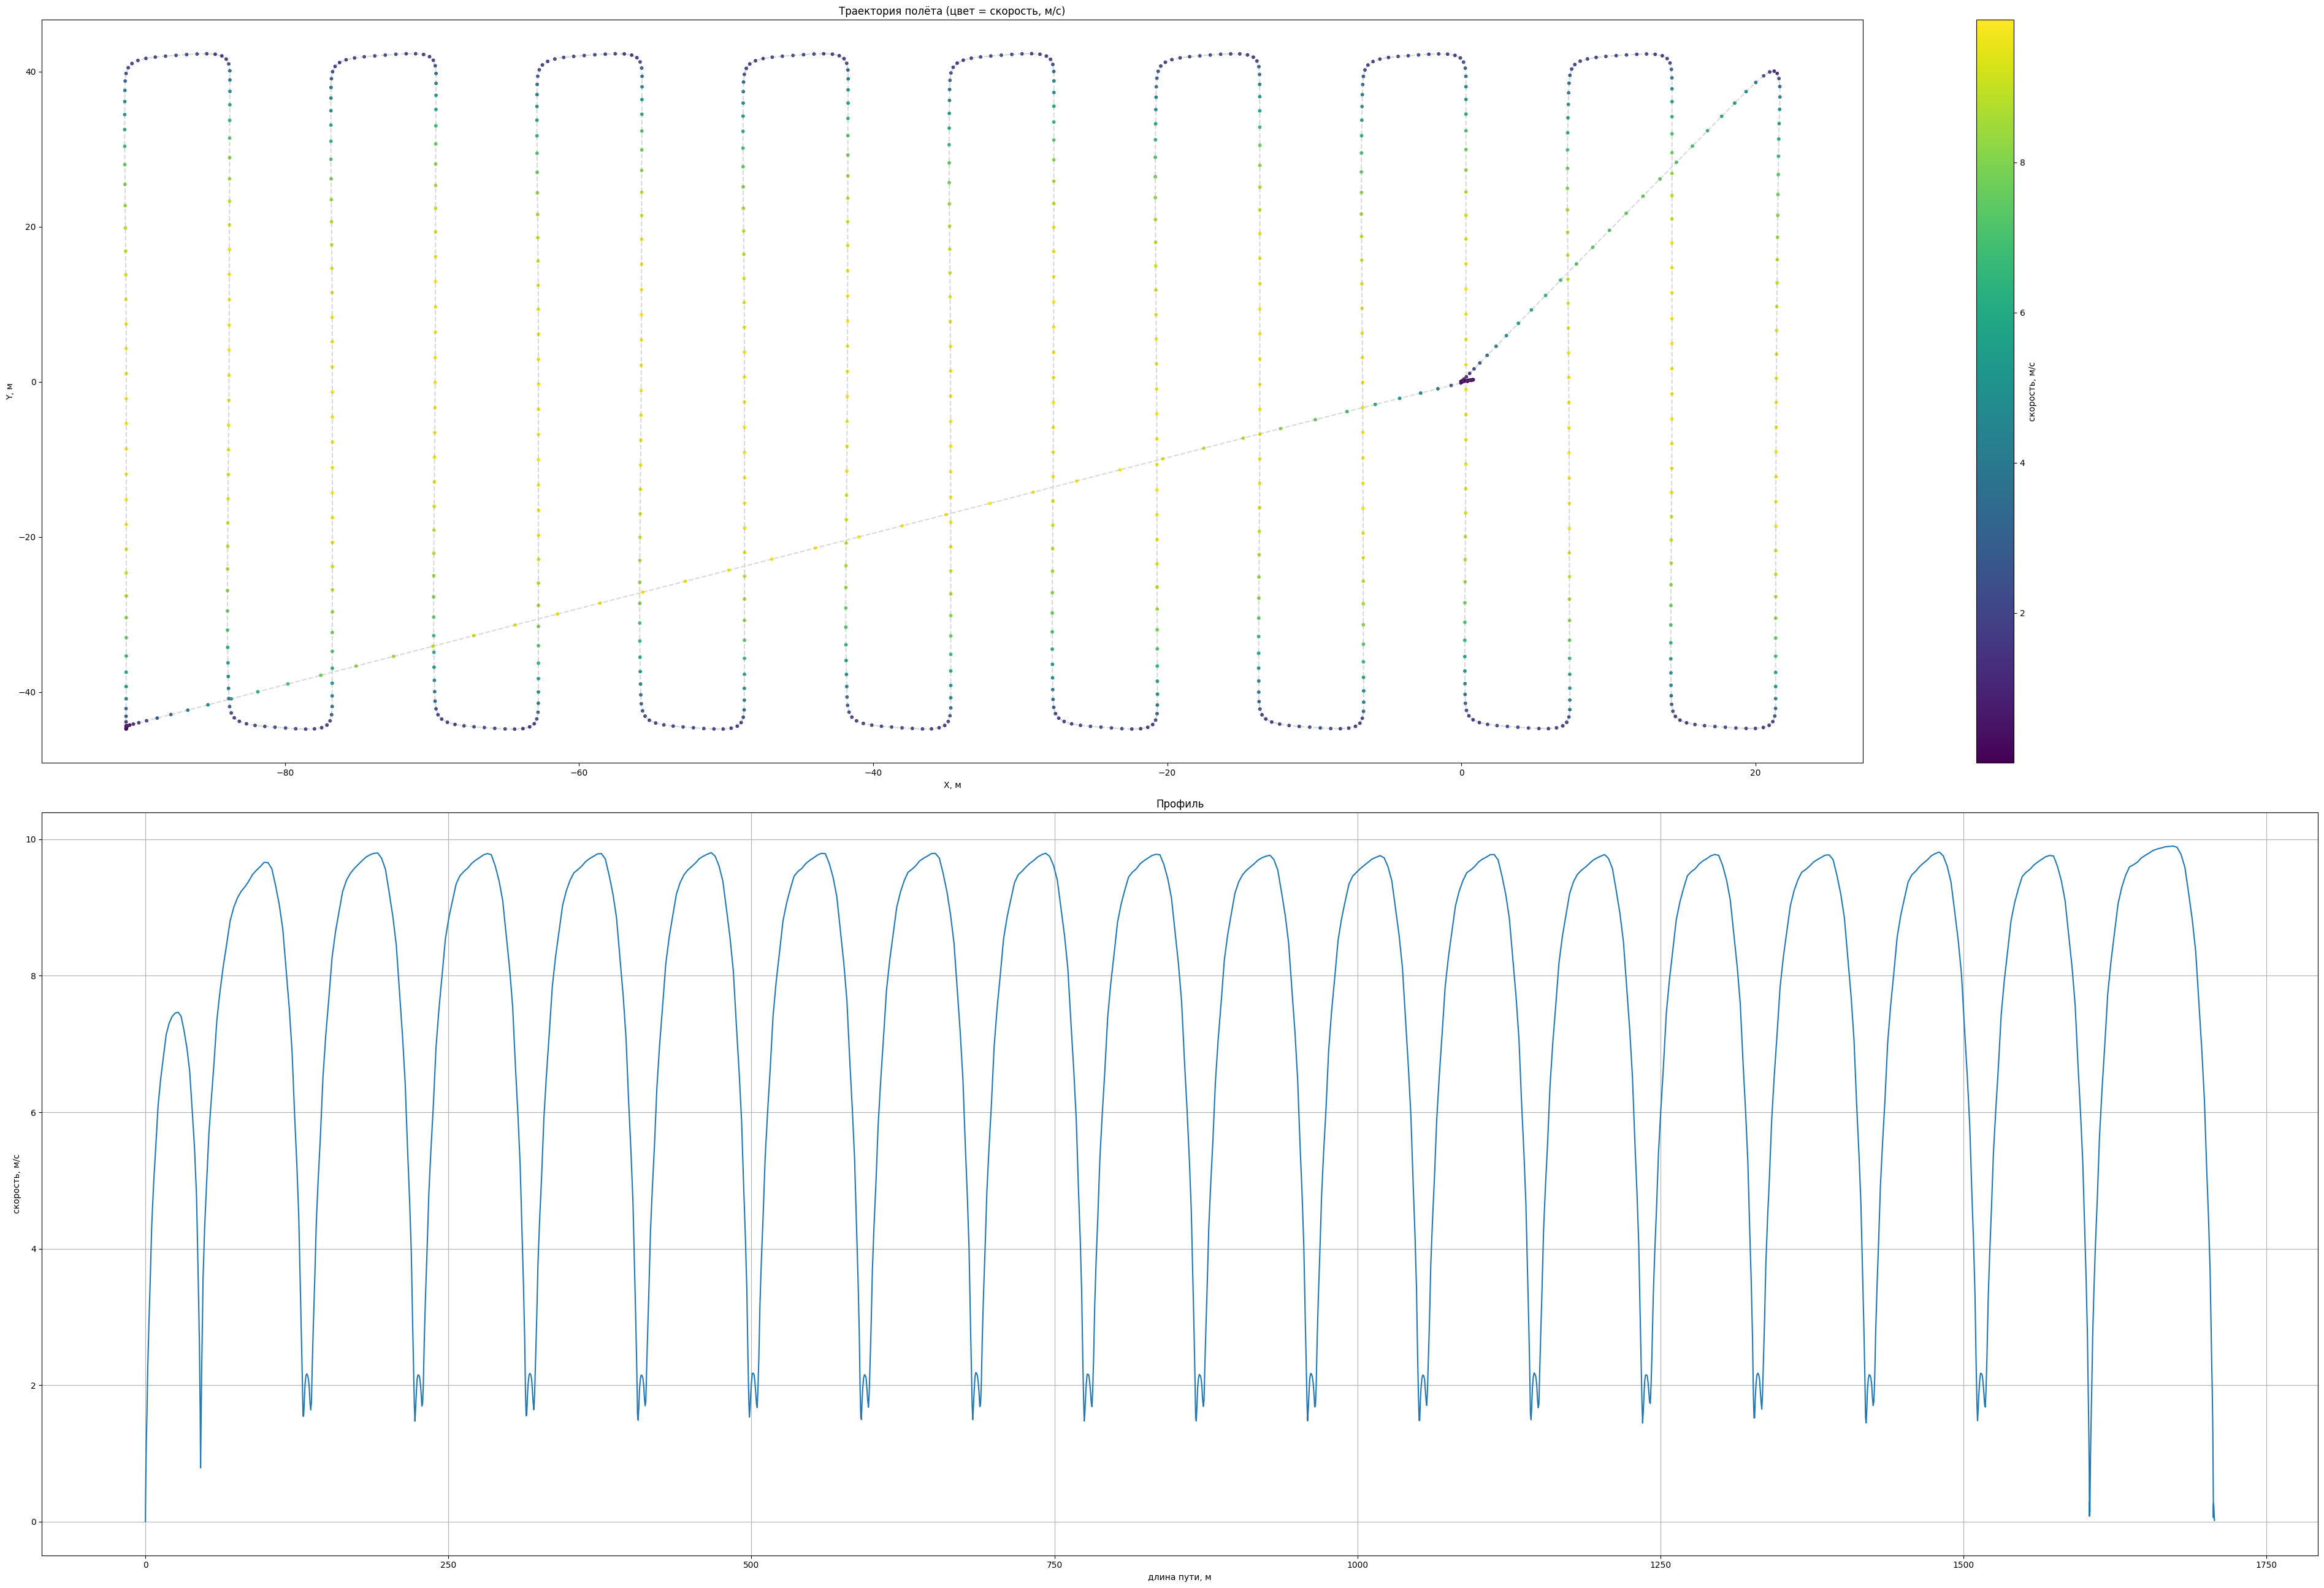

Полёт № 2


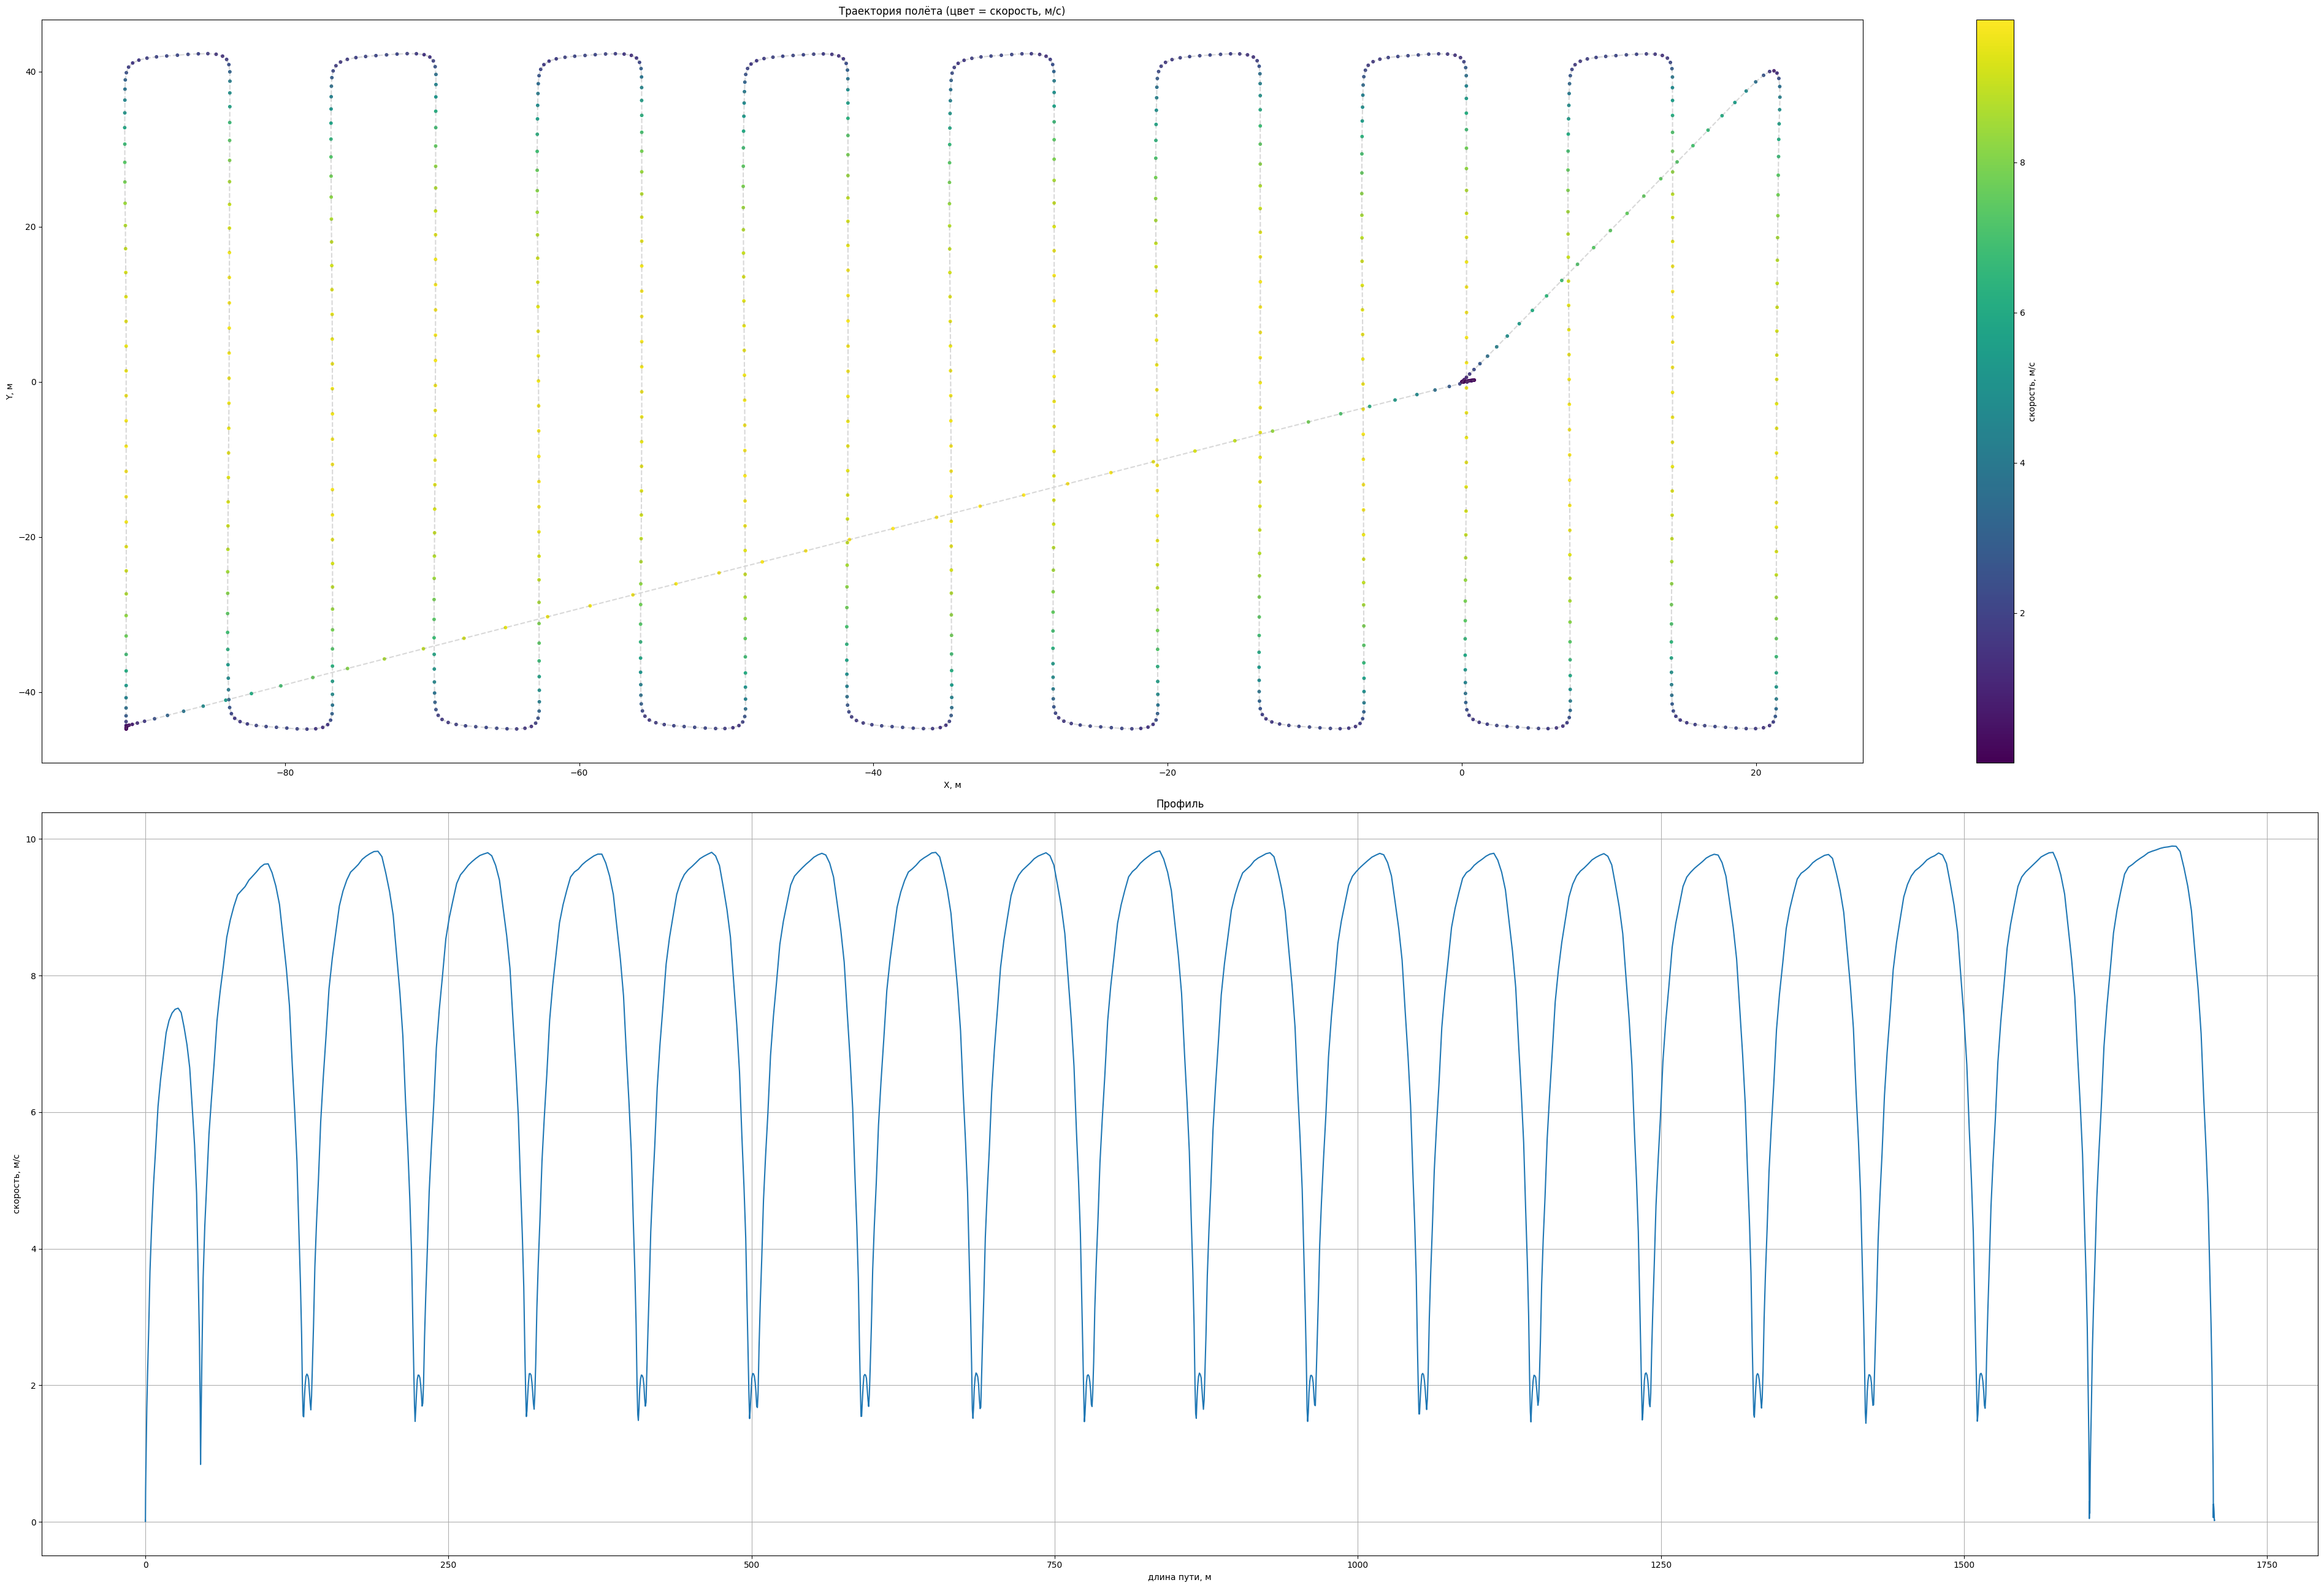

In [18]:
for i, f in enumerate(in_logs.flight_points, 1):
    print(f"Полёт № {i}")
    scatter_with_color_and_profile(f['points'], f['speed'])

## Берём один полёт для анализа

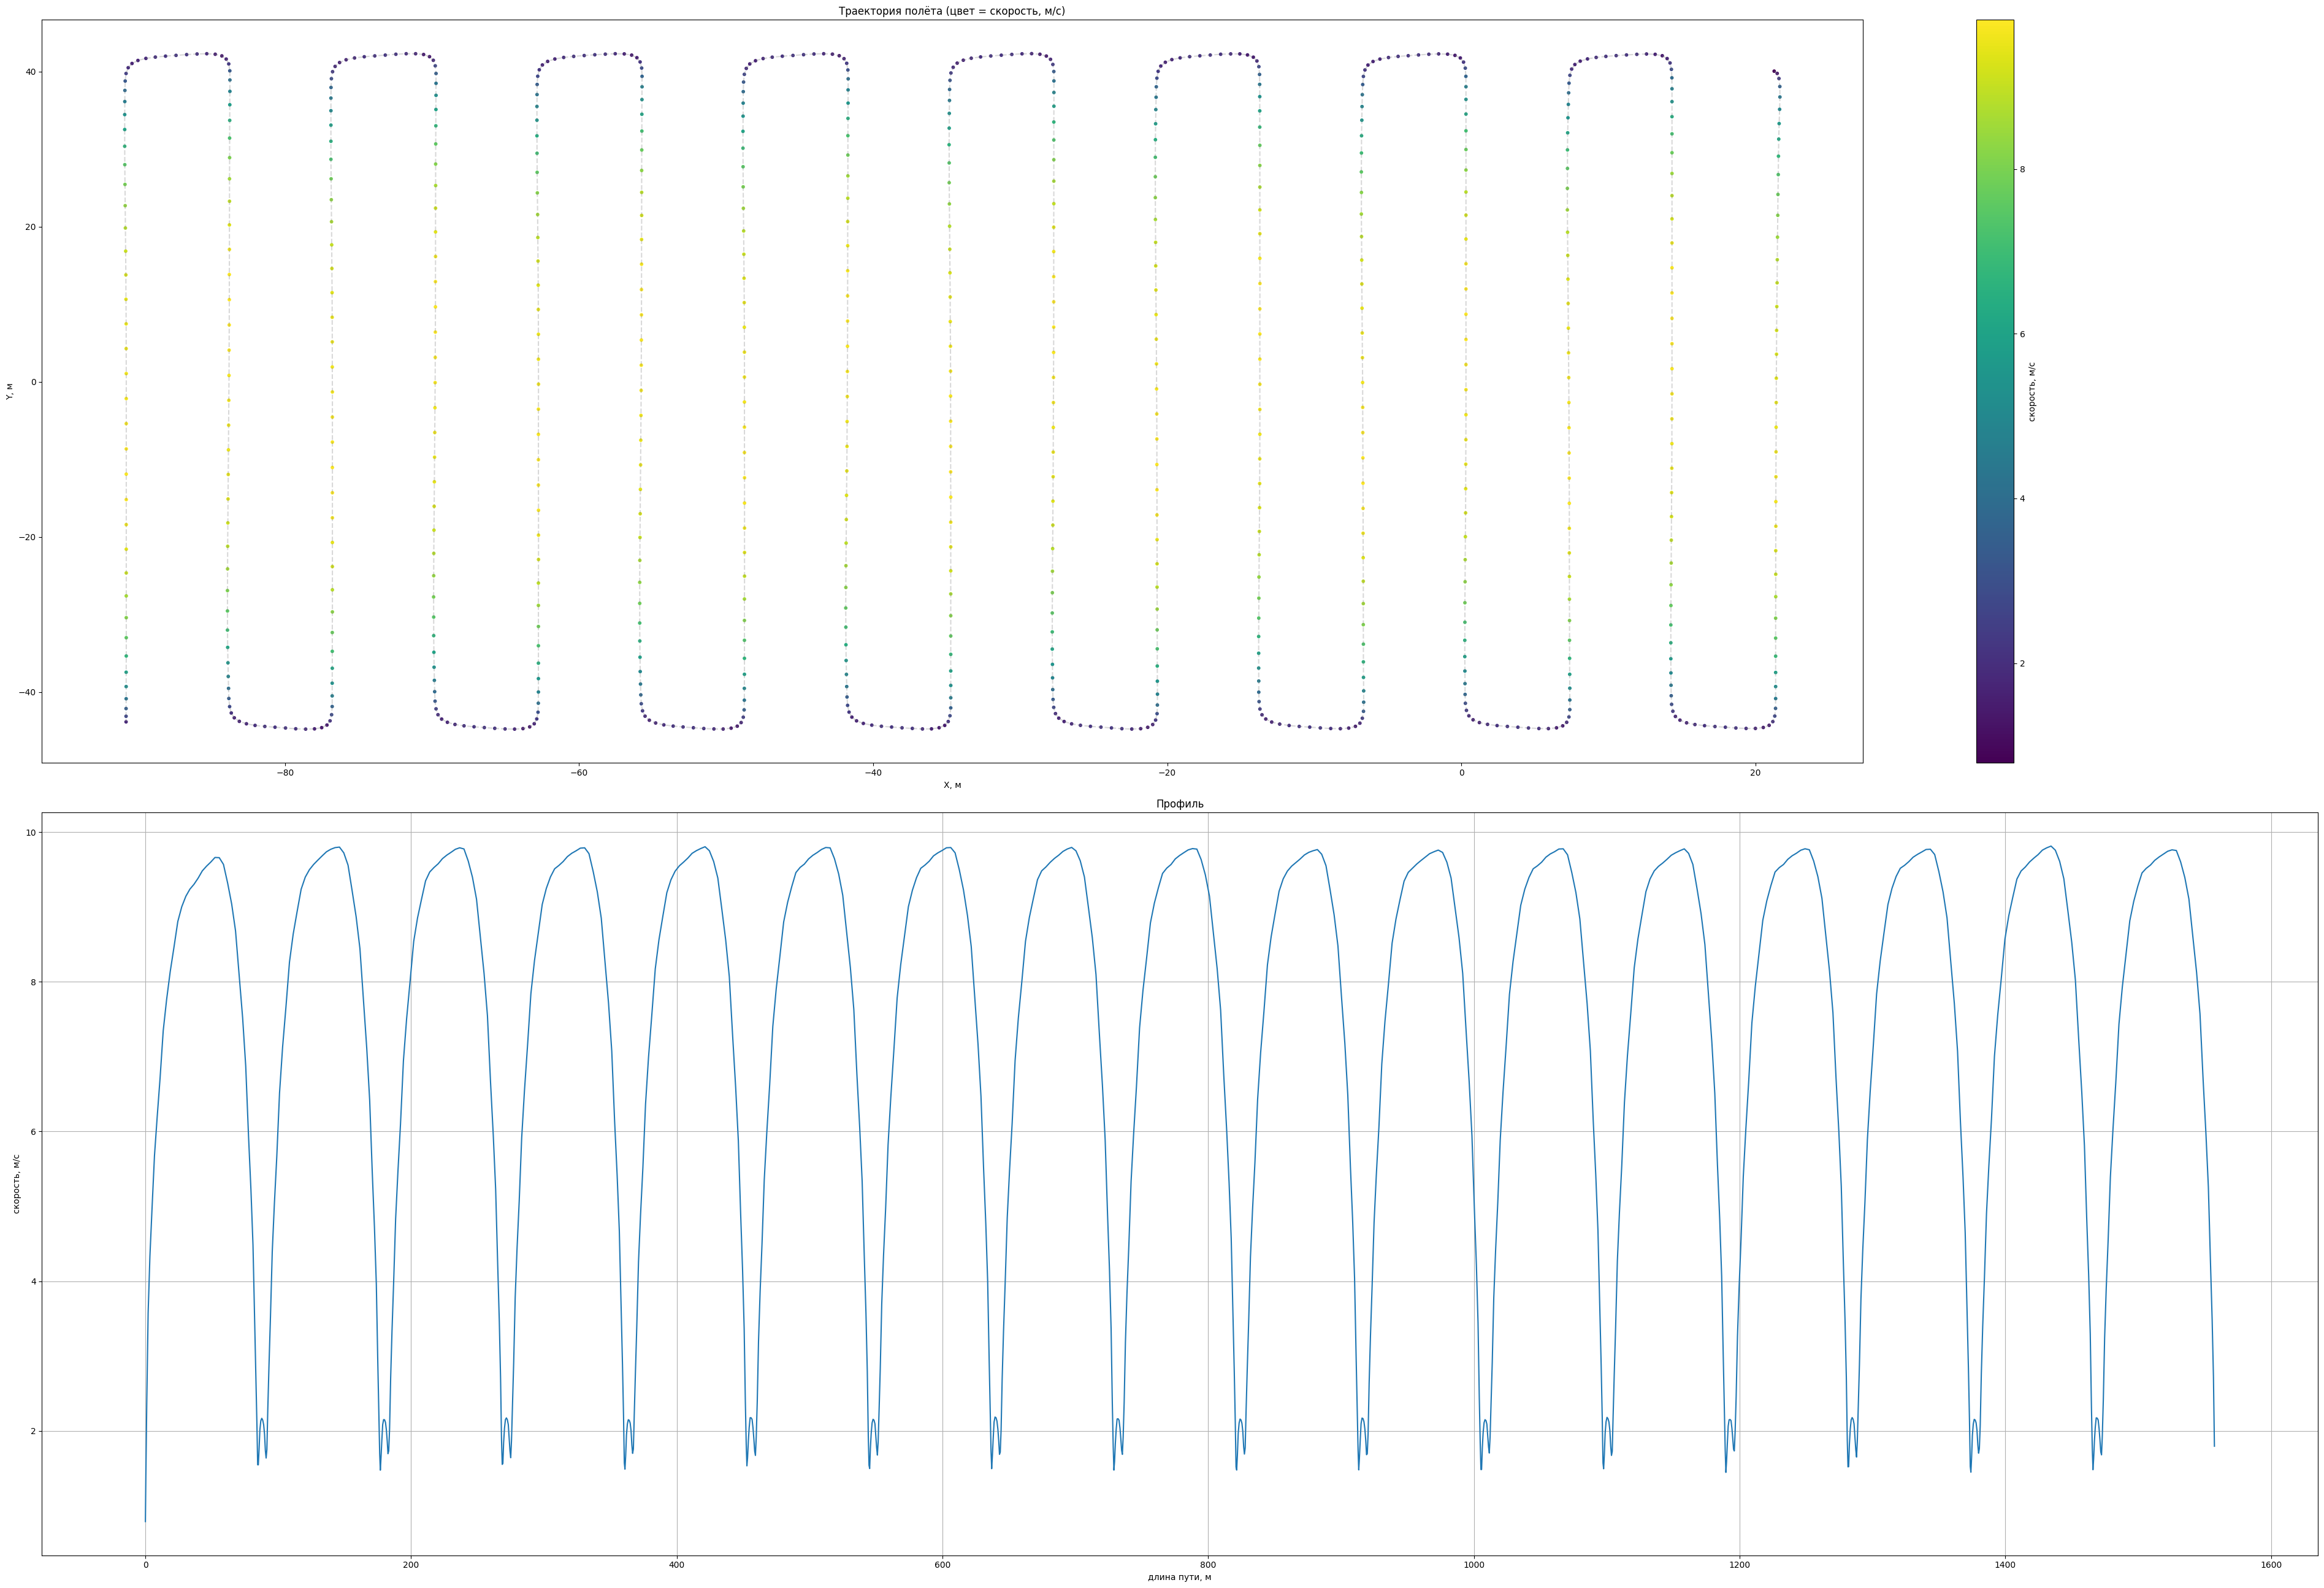

In [19]:
waypoints_by_logs, speed_list_by_logs = in_logs.get_waypoints_and_speed_list(index_fly=0)
scatter_with_color_and_profile(waypoints_by_logs, speed_list_by_logs)

## Предсказанный на основе логов

In [20]:
t_list = simulate_time_param(waypoints_by_logs, speed_list_by_logs)
profile_by_logs = predictor.build_profile(waypoints_by_logs)

pump_plan_by_logs = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list_by_logs,
    length=profile_by_logs.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile_by_logs.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(pump_plan_by_logs) :.2f} л")
empty_s_list = [profile_by_logs.distance_at_time(t) for t, v in pump_plan_by_logs.empty_events]

if pump_plan_by_logs.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(pump_plan_by_logs.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")


Длина маршрута L = 1557.38 м
Плановый объём V_total = 9.89 л
Фактически выльется (с учётом ограничений насоса): 10.24 л
Бак не опустошается в ходе полёта.


## Профиль скорости

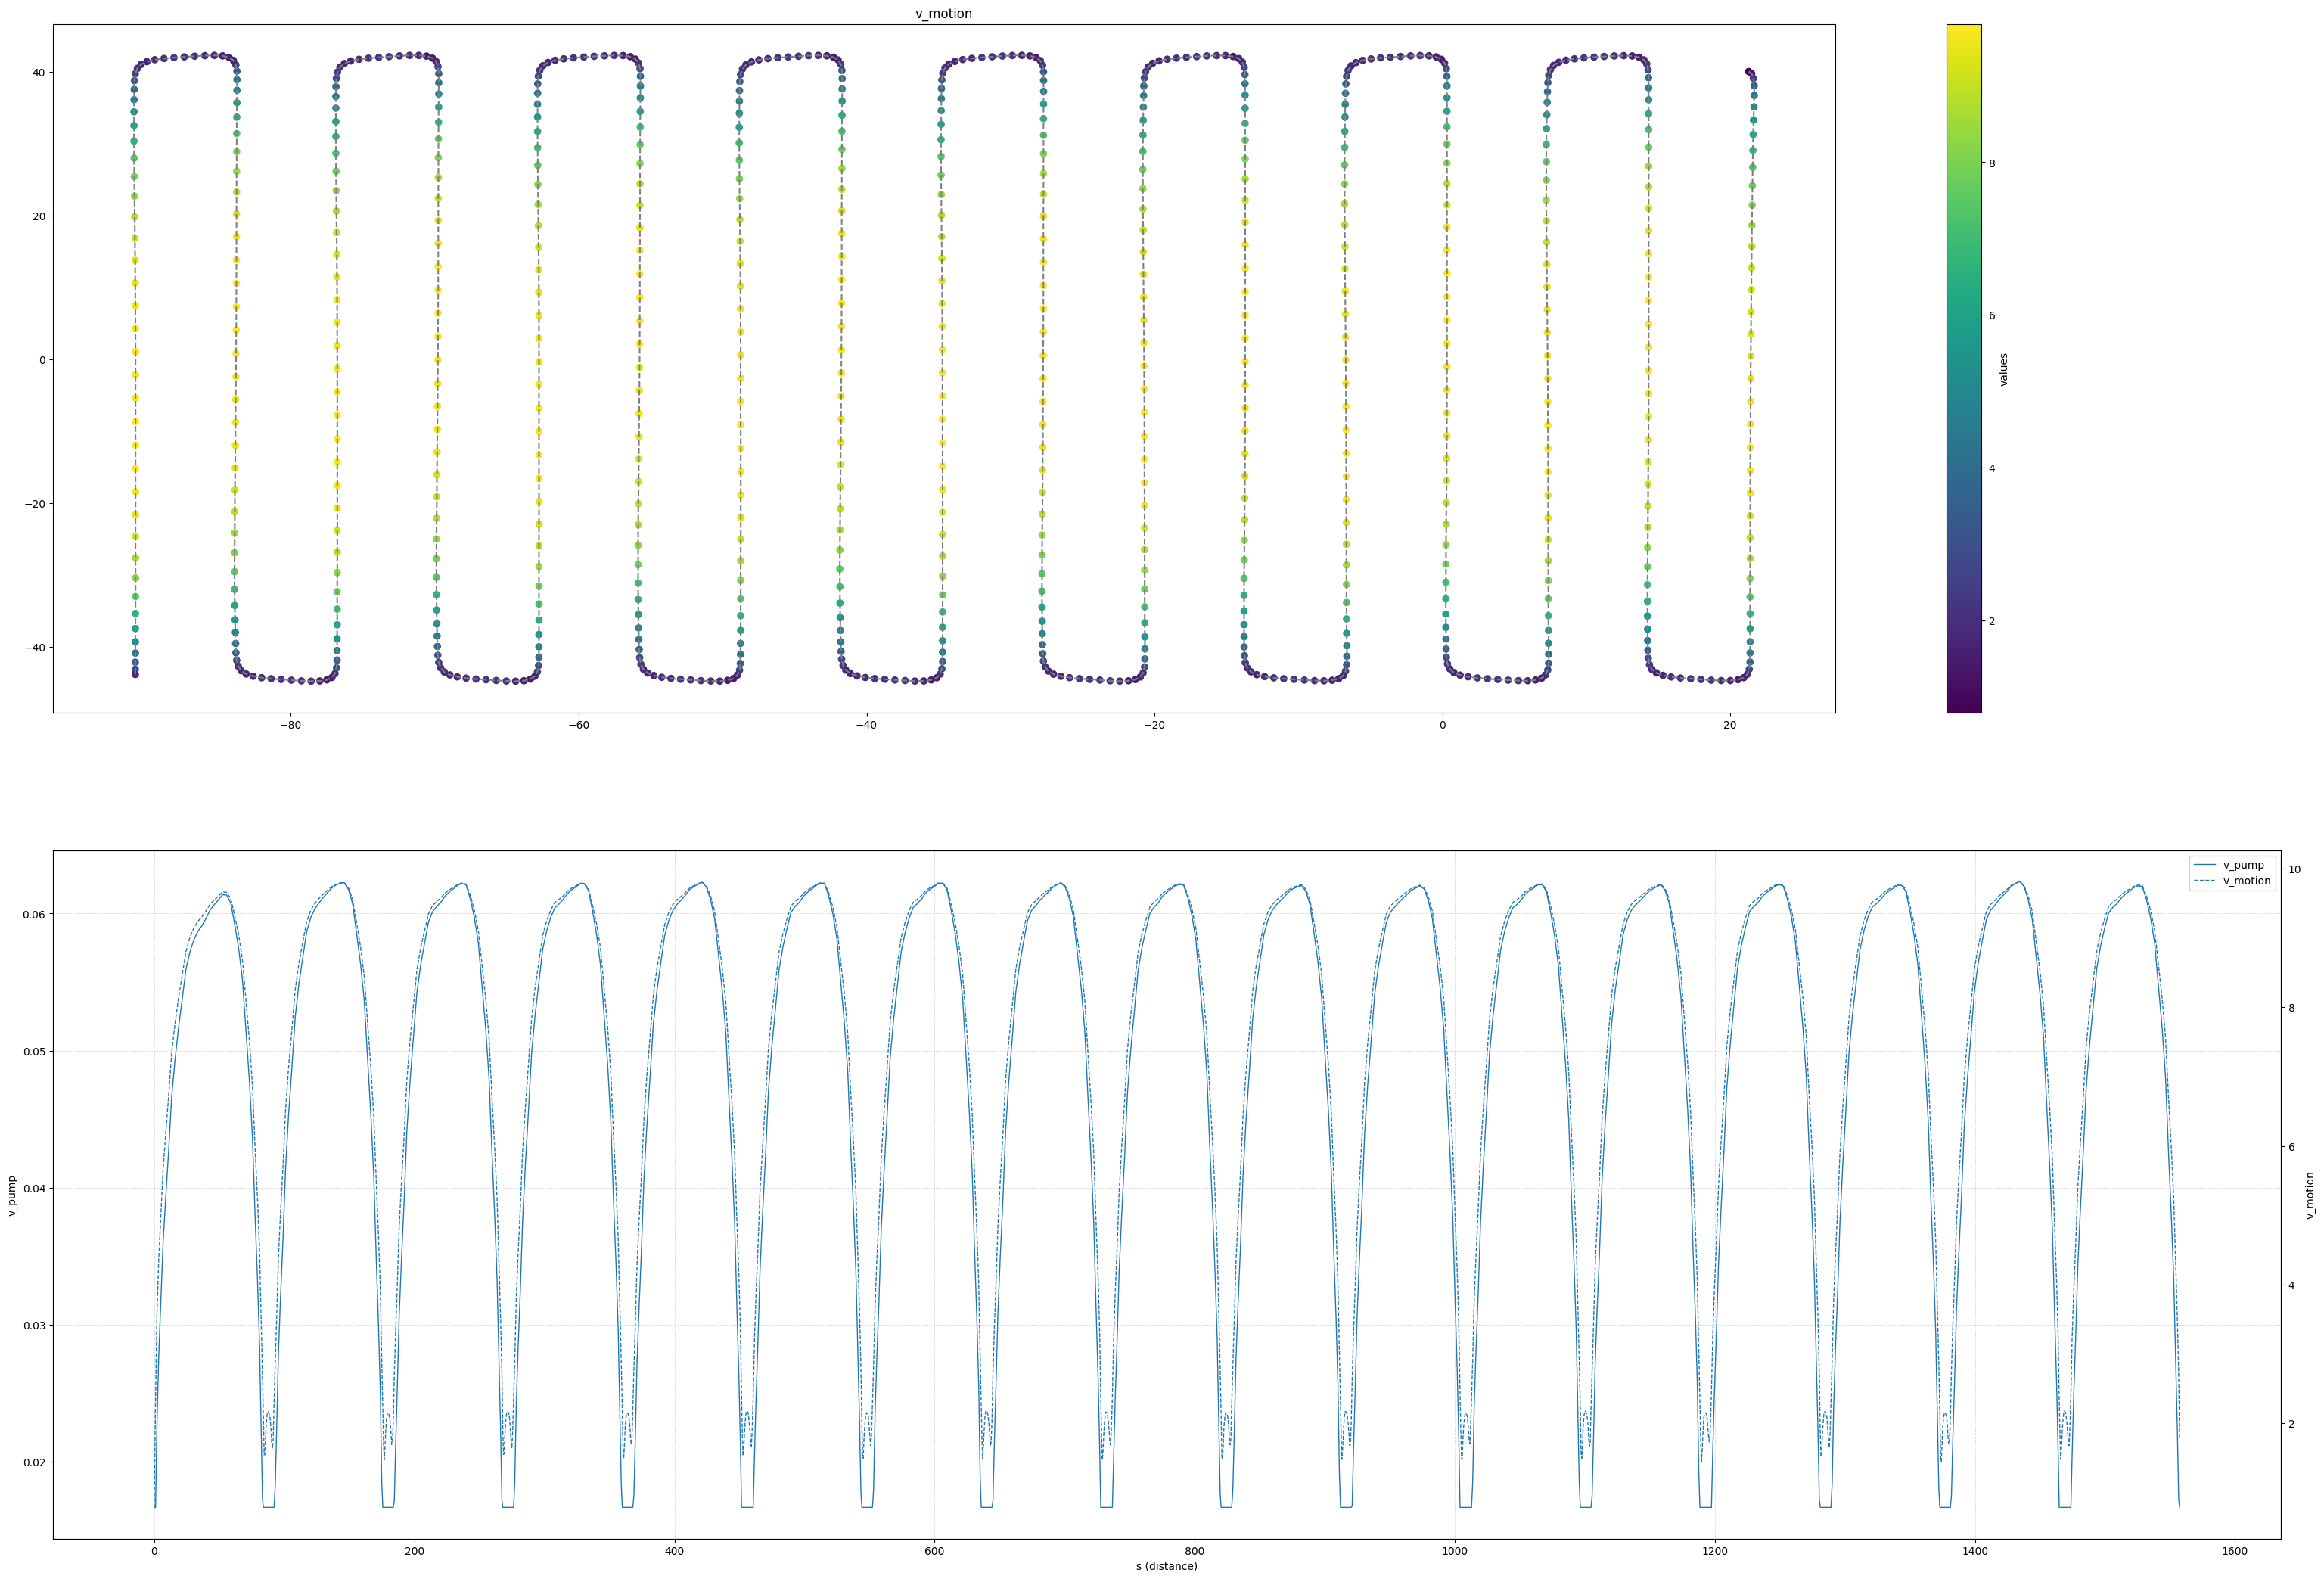

In [21]:
s_list_by_logs = polyline_lengths(waypoints_by_logs)
list_pts = [point_on_path(waypoints_by_logs, s) for s in s_list_by_logs]

plot_speeds_profile(list_pts,
                    s_list_by_logs,
                    pump_plan_by_logs.q,
                    speed_list_by_logs,
                    empty_s_list)

## Плотность внесения

count    795.000000
mean       0.007088
std        0.001380
min        0.006353
25%        0.006353
50%        0.006353
75%        0.007694
max        0.021128
dtype: float64
diff = 0.0007347800098017566
СКО = 2.442394078009241e-06


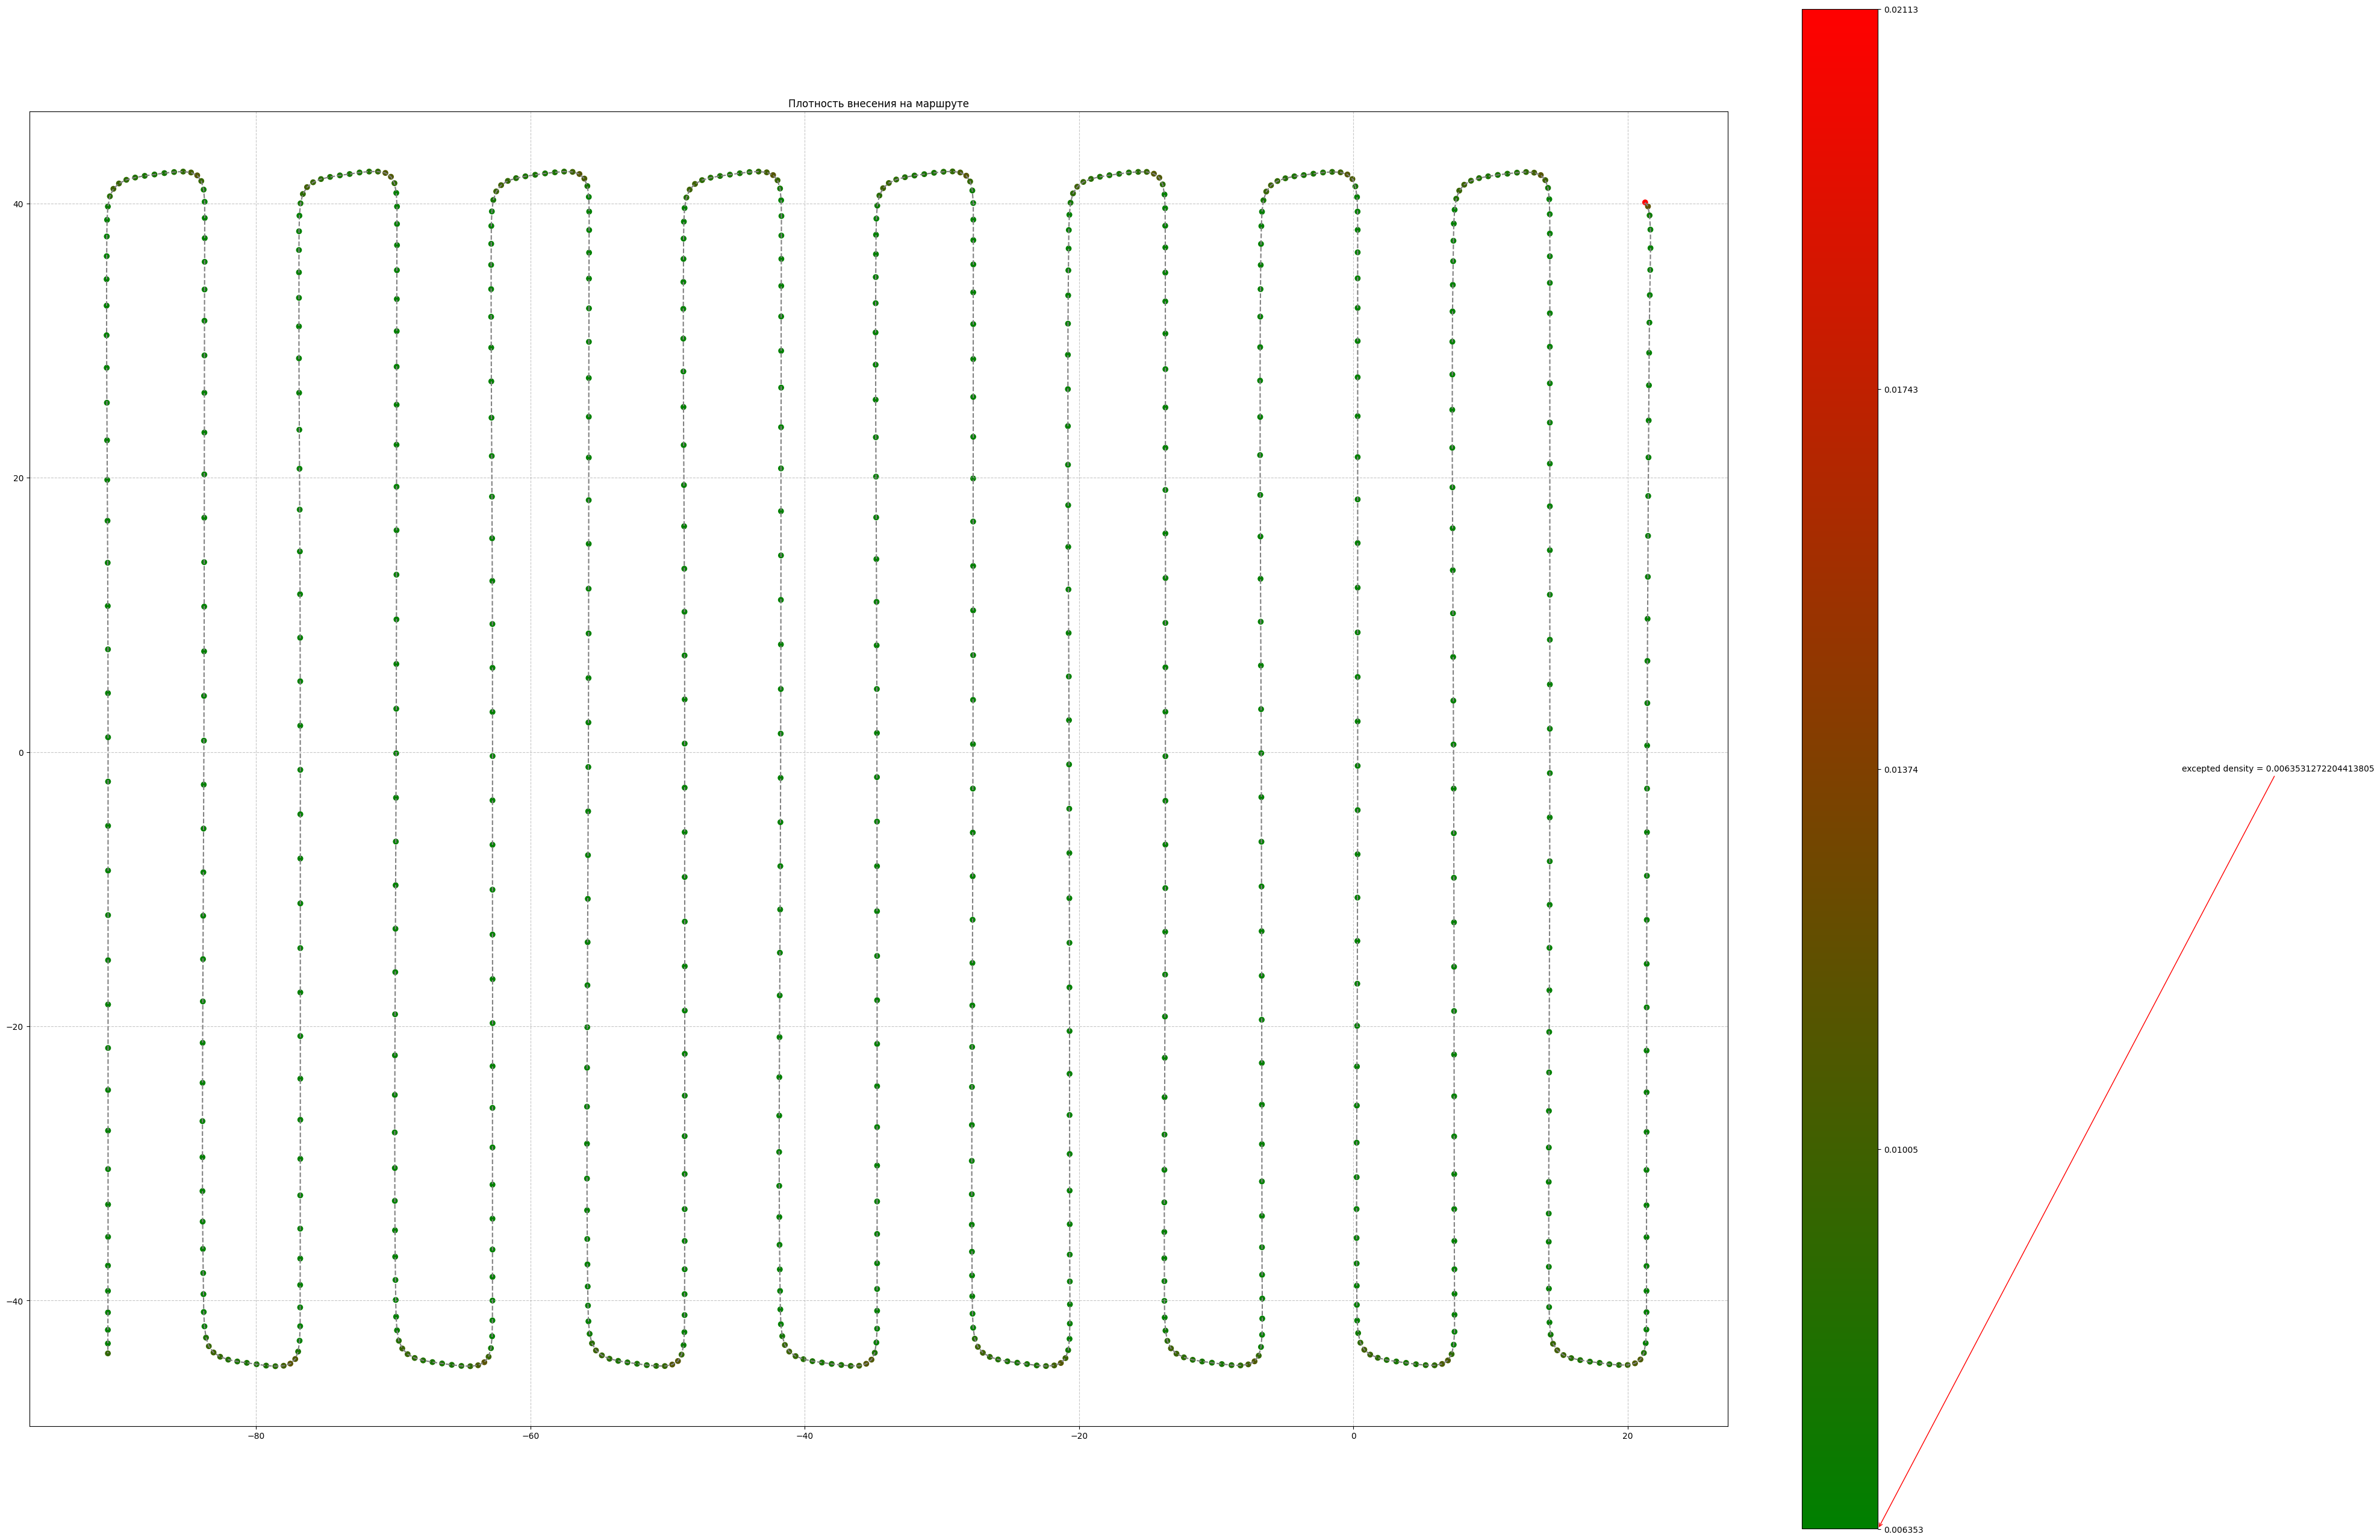

In [22]:
plot_density_profile(list_pts,
                     pump_plan_by_logs.q,
                     speed_list_by_logs,
                     V_total / profile_by_logs.total_distance)